<div style="display: flex; flex-direction: column; align-items: center; max-width: 100%; padding: 20px 0; margin: auto;">
    <img src="https://media.licdn.com/dms/image/v2/D4D3DAQFGx0XnuUvugA/image-scale_191_1128/image-scale_191_1128/0/1662458005755/nova_ims_information_management_school_cover?e=2147483647&v=beta&t=J3Q4LlZi36_4UAFhj2019QdtfXLn0kQwaX25jgaBhOQ" 
         alt="Logo" 
         style="width: 100%; max-width: 800px; height: auto; max-height: 150px; object-fit: cover; border: 3px solid hsla(120, 71.40%, 43.90%, 0.30); border-radius: 5px;">
    <div style="text-align: center; padding: 10px 0; max-width: 800px;">
        <h5 style="margin: 10px 0;">This analysis is conducted as part of the <b><i>Neural and Evolutionary Learning</i></b> course, a component of the Master's program in Data Science and Advanced Analytics at the <b><u>Nova Information Management School</u></b>.</h5>
    </div>
    <h1 style="color: hsla(120, 71.40%, 43.90%, 0.30); margin: 10px 0;"><b>Predict the Crude Protein Weight</b></h1>
</div>

<div style="text-align: center; margin: 20px 0;">
    <h3 style="margin-bottom: 15px;"><u>Group 22</u></h3>
    <table style="margin: 0 auto; border-collapse: collapse; width: 80%; max-width: 500px;">
        <thead>
            <tr>
                <th style="border-bottom: 1px solid #ddd; padding: 8px;">Student Name</th>
                <th style="border-bottom: 1px solid #ddd; padding: 8px;">Student ID</th>
            </tr>
        </thead>
        <tbody>
            <tr>
                <td style="border-bottom: 1px solid #ddd; padding: 8px;">Catarina Nunes</td>
                <td style="border-bottom: 1px solid #ddd; padding: 8px;">20230083</td>
            </tr>
            <tr>
                <td style="border-bottom: 1px solid #ddd; padding: 8px;">Sofia Jacinto</td>
                <td style="border-bottom: 1px solid #ddd; padding: 8px;">20240598</td>
            </tr>
            <tr>
                <td style="padding: 8px;">José Cavaco</td>
                <td style="padding: 8px;"> 20240513</td>
            </tr>
        </tbody>
    </table>
</div>

<a id="idx"></a>
<div style="background-color: hsla(120, 71.40%, 43.90%, 0.30); padding: 10px; border-radius: 8px; text-align: center; margin-top: 20px; margin-bottom: 20px;">
    <h1 style="color: white; margin: 0;">Index</h1>
</div>

1. [Preprocessing the data](#preprocessing)
2. [Choosing the method and parameters](#method-selection)
3. [Estimating the predictive error](#error-estimation)
4. [Inducing the final model](#model-induction)
5. [Testing the final model](#final-testing)

#### Metadata

|Feature |Definition|
|----|-----|
|wing_tag |Chicken unique ID|
|weight |The chicken total weight|
|hot_carcass_weight |The weight of the carcass immediately after slaughter|
|carcass_weight_with_head_and_legs |The weight of the carcass including the head and legs|
|cold_carcass_weight| The weight of the carcass after cooling|
|breast_weight |The weight of the breast meat of the chicken|
|thigh_weight |The weight of the thigh meat of the chicken|
|spleen |The weight of the chicken’s spleen|
|liver |The weight of the chicken’s liver|
|heart |The weight of the chicken’s heart|
|intestine |The weight of the chicken’s intestine|
|empty_muscular_stomach| Indicates the presence or absence of the empty muscular stomach of the chicken|
|glandular_stomach |The weight of the chicken’s glandular stomach|
|crude_protein| The weight of crude protein in the carcass|
|ether_extract |The weight of ether extract, which measures the total fat in the carcass|

#### Imports & Settings

In [1]:
#pip install -r requirements.txt
# pip install neat-python

In [2]:
# Standard library imports
import os
import gc
import pickle
import datetime
import random
import warnings
from collections import Counter
from itertools import product

# Third-party numerical/scientific computing
import numpy as np
import pandas as pd
import scikit_posthocs as sp
from scipy.stats import wilcoxon, friedmanchisquare

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_decision_regions
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tqdm import tqdm
from IPython.display import display, HTML

# Machine Learning
from sklearn.datasets import fetch_openml
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, make_scorer

# Deep Learning (PyTorch)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# Deep Learning (TensorFlow/Keras)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD, RMSprop, Adam

#NEAT
import sys
import torch
import neat
import visualize
import json
import shutil
import ast
from neat import nn, Config, DefaultGenome, DefaultReproduction, DefaultSpeciesSet, DefaultStagnation
import visualize

# Custom/local imports
from slim.main_gp import gp
from slim_gsgp.main_gsgp import gsgp
from slim_gsgp.main_slim import slim
from slim_gsgp.datasets.data_loader import *
from slim.evaluators.fitness_functions import rmse
from slim.utils.utils import train_test_split

import time

# Suppress warnings
warnings.filterwarnings('ignore')

C:\Users\catar\AppData\Local\Temp\ipykernel_6684\1765553042.py:59: DeprecationWarning: The `gsgp_slim` package is deprecated. Please use the `slim_gsgp` package instead: https://pypi.org/project/slim_gsgp/
  from slim.main_gp import gp


In [3]:
os.environ["PATH"] += os.pathsep + "C:\\Program Files\\Graphviz\\bin"

In [4]:
seed = 42
np.random.seed(seed)
random.seed(seed)

In [5]:
train_color = 'blue'
test_color = 'orange'

In [6]:
#! ls

#### Helpfull Functions

In [7]:
def plot_boxplots(df_clients, columns):
    """
    Plot multiple boxplots horizontally with scrolling enabled.
    """
    n_cols = len(columns)
    
    fig = make_subplots(
        rows=1,
        cols=n_cols,
        shared_yaxes=False,
        horizontal_spacing=0.05,  # space between boxplots
        subplot_titles=[col.replace("_", " ").title() for col in columns]
    )

    for idx, column in enumerate(columns, start=1):
        fig.add_trace(
            go.Box(
                y=df_clients[column],
                name=column.replace("_", " ").title(),
                boxpoints='outliers',  # only show outliers
                whiskerwidth=0.2,
                marker_color='mediumseagreen',
                line_color='seagreen',
                fillcolor='rgba(60,179,113,0.3)',
                marker_size=4
            ),
            row=1,
            col=idx
        )

    fig.update_layout(
        title='Outliers Analysis',
        title_font_size=24,
        plot_bgcolor='white',
        height=600,
        width=300 * n_cols,  # make width proportional to number of boxplots
        showlegend=False
    )

    fig.update_yaxes(zeroline=False)

    fig.show()

### <a id="preprocessing"></a> 
<div style="background-color: hsla(120, 71.40%, 43.90%, 0.30); padding: 10px; border-radius: 8px; text-align: center; margin-top: 20px; margin-bottom: 20px;">
    <h3 style="color: white; margin: 0;">Preprocessing the data</h3>
</div>

[Back to Index](#idx)

#### Data Loading

In [8]:
df = pd.read_excel(r"data\sustavianfeed.xlsx")

In [9]:
df.head()

,WING TAG,WEIGHT,HOT CARCASS WEIGHT,CARCASS WEIGHT WITH HEAD AND LEGS,COLD CARCASS WEIGHT,BREAST WEIGHT (2),THIGH WEIGHT (2),SPLEEN,LIVER,HEART,INTESTINE,EMPTY MUSCULAR STOMACH,GLANDULAR STOMACH,CRUDE PROTEIN,ETHER EXTRACT
0,G403,2223.3,1429.6,1725.6,1394.0,214.0,489.4,3.716,38.636,9.305,123.171,/,13.170,86.105469,0.38
1,G439,2201.9,1450.2,1769.8,1405.4,236.0,538.7,3.494,34.725,10.084,71.800,45.273,9.781,86.143472,1.66
2,G454,2159.9,1398.4,1724.9,1461.7,241.8,512.1,4.023,31.932,10.635,61.380,/,6.217,86.416898,0.98
3,G465,2198.7,1473.9,1800.4,1425.1,227.7,549.9,3.087,32.326,11.927,64.879,35.861,8.358,85.959935,1.10
4,G428,2003.2,1291.2,1581.6,1260.1,224.7,473.2,3.723,30.105,9.855,68.562,36.526,7.572,81.693637,6.34


lets rename the columns according to the metadata:

In [10]:
# column name mapping
column_mapping = {
    'WING TAG': 'wing_tag',
    'WEIGHT': 'weight',
    'HOT CARCASS WEIGHT': 'hot_carcass_weight',
    'CARCASS WEIGHT WITH HEAD AND LEGS': 'carcass_weight_with_head_and_legs',
    'COLD CARCASS WEIGHT': 'cold_carcass_weight',
    'BREAST WEIGHT (2)': 'breast_weight',
    'THIGH WEIGHT (2)': 'thigh_weight',
    'SPLEEN': 'spleen',
    'LIVER': 'liver',
    'HEART': 'heart',
    'INTESTINE': 'intestine',
    'EMPTY MUSCULAR STOMACH': 'empty_muscular_stomach',
    'GLANDULAR STOMACH': 'glandular_stomach',
    'CRUDE PROTEIN': 'crude_protein',
    'ETHER EXTRACT': 'ether_extract'
}

df = df.rename(columns=column_mapping)

#### Descriptive Summary

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
weight,96.0,2339.682292,200.943424,1968.400000,2201.775000,2299.500000,2473.800000,2890.500000
hot_carcass_weight,96.0,1521.955208,144.126939,1284.900000,1425.775000,1493.050000,1608.400000,1929.400000
carcass_weight_with_head_and_legs,96.0,1833.378125,154.000550,1554.400000,1723.800000,1809.400000,1922.725000,2262.800000
cold_carcass_weight,96.0,1481.479167,142.830115,1252.600000,1380.825000,1452.800000,1573.700000,1891.700000
breast_weight,96.0,234.116667,37.818405,177.100000,218.775000,231.550000,243.275000,533.200000
thigh_weight,96.0,542.205208,60.994468,177.800000,508.225000,538.100000,573.850000,690.600000
spleen,96.0,4.219917,0.998836,2.464000,3.534250,4.048000,4.817000,7.758000
liver,96.0,36.781427,5.438894,25.916000,33.053000,35.936000,40.485000,53.133000
heart,96.0,12.059240,1.932239,8.561000,10.584250,11.679000,13.449750,17.194000
intestine,96.0,69.149156,11.727467,44.133000,62.274250,68.019500,75.103000,123.171000


In [12]:
df.describe(include='O').T

,count,unique,top,freq
wing_tag,96,96,G403,1
empty_muscular_stomach,96,91,/,5


In [13]:
df.isna().sum()

wing_tag                             0
weight                               0
hot_carcass_weight                   0
carcass_weight_with_head_and_legs    0
cold_carcass_weight                  0
breast_weight                        0
thigh_weight                         0
spleen                               0
liver                                0
heart                                0
intestine                            0
empty_muscular_stomach               0
glandular_stomach                    0
crude_protein                        0
ether_extract                        0
dtype: int64

- no missing values
- `wing_tag` uniquely represents each chicken so can be placed as index.

In [14]:
df.set_index('wing_tag', inplace = True)

In [15]:
df.duplicated().sum()

0

#### Data Types

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96 entries, G403 to V428
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   weight                             96 non-null     float64
 1   hot_carcass_weight                 96 non-null     float64
 2   carcass_weight_with_head_and_legs  96 non-null     float64
 3   cold_carcass_weight                96 non-null     float64
 4   breast_weight                      96 non-null     float64
 5   thigh_weight                       96 non-null     float64
 6   spleen                             96 non-null     float64
 7   liver                              96 non-null     float64
 8   heart                              96 non-null     float64
 9   intestine                          96 non-null     float64
 10  empty_muscular_stomach             96 non-null     object 
 11  glandular_stomach                  96 non-null     float64
 

In [17]:
df['empty_muscular_stomach'].unique()

array(['/', 45.273, 35.861, 36.526, 40.993, 40.949, 45.323, 42.091,
       49.148, 46.807, 31.103, 49.057, 39.621, 43.128, 53.485, 38.836,
       44.487, 47.665, 50.006, 43.695, 59.547, 61.306, 61.702, 60.063,
       45.428, 53.456, 43.586, 49.648, 63.571, 47.523, 63.86, 64.538,
       42.852, 50.119, 32.665, 35.164, 46.656, 44.855, 44.962, 51.851,
       45.507, 50.136, 43.821, 66.616, 29.712, 40.936, 52.518, 35.408,
       51.944, 41.483, 56.23, 55.663, 42.66, 32.12, 43.964, 75.767,
       45.327, 42.129, 47.964, 44.811, 32.599, 32.947, 38.155, 48.009,
       56.347, 59.583, 51.322, 58.708, 41.917, 40.425, 51.903, 56.698,
       40.7, 45.321, 55.671, 68.602, 44.006, 54.71, 45.636, 34.692,
       48.933, 45.045, 48.02, 42.632, 45.366, 52.457, 49.281, 54.021,
       42.173, 49.7, 46.816], dtype=object)

The metadata for the column `empty_muscular_stomach` specifies that it should be a binary flag, '_Indicates the presence or absence of the empty muscular stomach of the chicken_'. However, the data contains a '/' that represents 'yes' for an empty stomach, and other values that indicate that the stomach is not empty, such as percentages or grams. We will evaluate whether it is more valuable to maintain this column as a float or a binary flag, based on its correlation with the target variable. Ultimately, we plan to adhere to the guidance provided in the metadata, but lets see:

In [18]:
df['empty_muscular_stomach_bin'] = np.where(
    df['empty_muscular_stomach'] == '/', 1, 0
).astype(int)

In [19]:
df['empty_muscular_stomach_float'] = df['empty_muscular_stomach'].replace('/', 0).astype(float)

#### Outliers

In [20]:
plot_boxplots(df, df.columns)

Given the presence of outliers and the small size of the dataset, the best approach is to incorporate the Robust Scaler into the model's pipeline.

#### Correlations

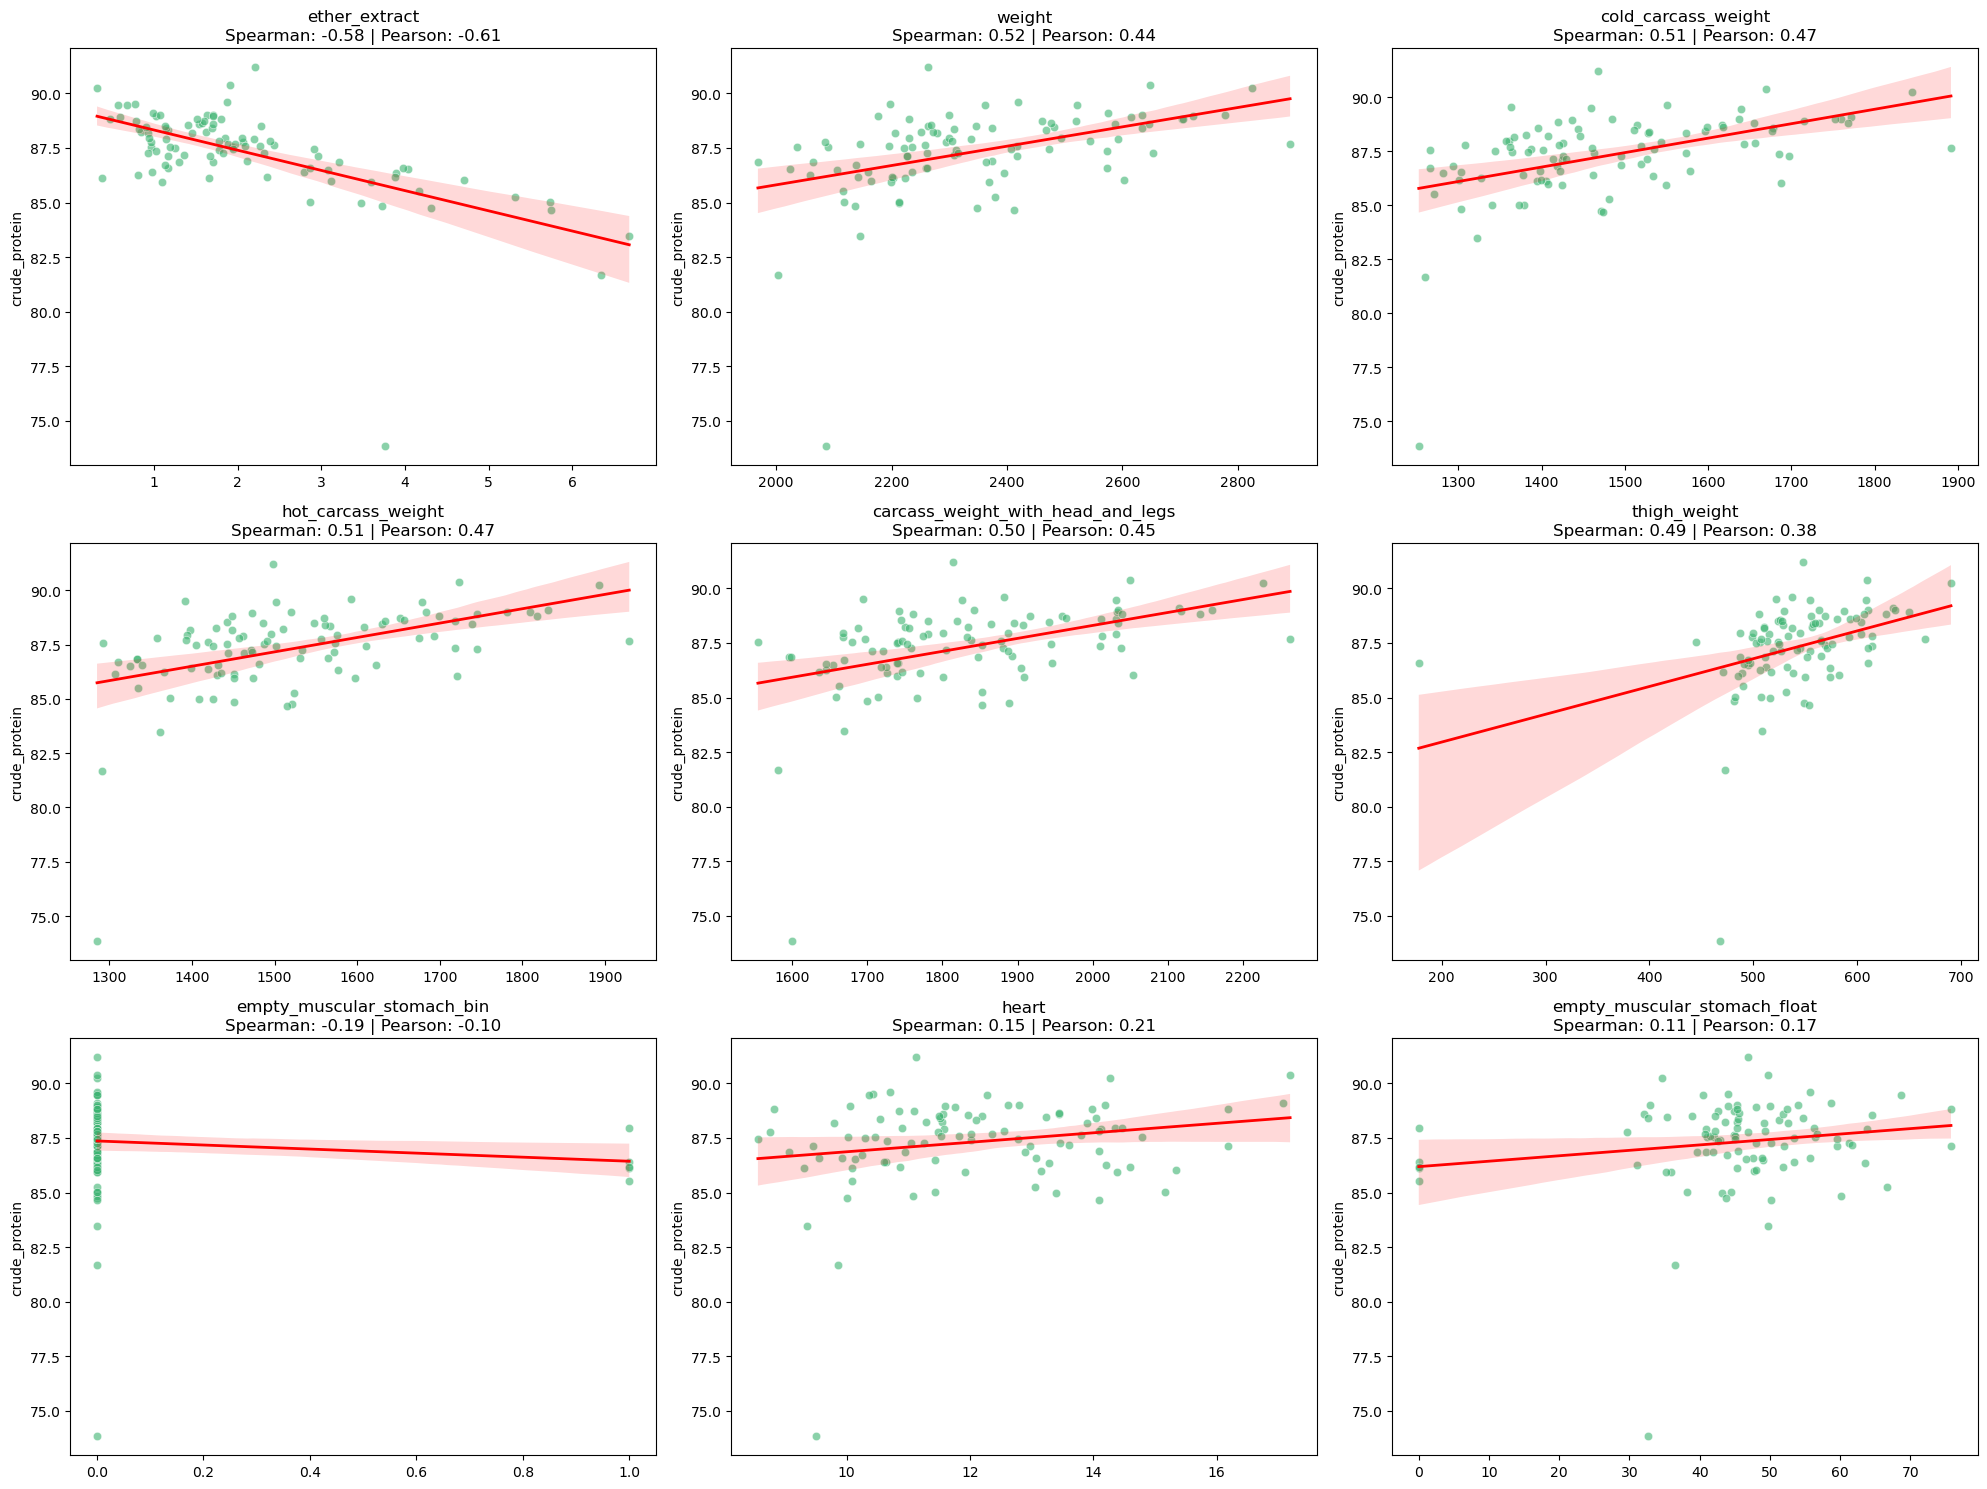

Correlations with crude_protein:


,spearman,pearson
feature,,
ether_extract,-0.582762,-0.612023
weight,0.519340,0.435335
cold_carcass_weight,0.509838,0.467681
hot_carcass_weight,0.508193,0.466773
carcass_weight_with_head_and_legs,0.498589,0.446827
thigh_weight,0.485786,0.379469
empty_muscular_stomach_bin,-0.190323,-0.101427
heart,0.153040,0.205162
liver,0.145050,0.123440


In [21]:
#code adapted from previous work

# correlations with crude_protein
target = 'crude_protein'
numeric_cols = df.select_dtypes(include=['number']).columns
features = [col for col in numeric_cols if col != target] 

# both correlation types
corr_data = df[features + [target]]  # Note: target needs to be in a list
spearman_corr = corr_data.corr(method='spearman')[target]
pearson_corr = corr_data.corr(method='pearson')[target]

# Combine into a DataFrame for easier analysis
corr_df = pd.DataFrame({
    'feature': features,
    'spearman': spearman_corr[features],
    'pearson': pearson_corr[features]
}).sort_values(by='spearman', key=abs, ascending=False)

# Set threshold (adjust as needed)
threshold = 0.15
significant_features = corr_df[(abs(corr_df['spearman']) >= threshold) | 
                             (abs(corr_df['pearson']) >= threshold)]

# Plot settings
num_features = len(significant_features)
num_cols = 3
num_rows = (num_features + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5*num_rows))
if num_features > 0:  # Only proceed if there are significant features
    if num_rows == 1:
        axes = axes.reshape(1, -1)  # Ensure axes is always 2D

    # Plot each significant feature against target
    for i, (_, row) in enumerate(significant_features.iterrows()):
        ax = axes[i//num_cols, i%num_cols]
        feature = row['feature']
        
        # Scatterplot
        sns.scatterplot(x=df[feature], y=df[target], ax=ax, color='mediumseagreen', alpha=0.6)
        
        # Regression line if possible
        if df[feature].nunique() > 1:
            try:
                sns.regplot(x=df[feature], y=df[target], ax=ax, 
                            scatter=False, color='red', line_kws={'linewidth':2})
            except:
                pass
        
        # Add correlation info to title
        ax.set_title(f"{feature}\nSpearman: {row['spearman']:.2f} | Pearson: {row['pearson']:.2f}")
        ax.set_xlabel('')
        ax.set_ylabel('crude_protein')

    # Hide empty subplots
    for j in range(i+1, num_rows*num_cols):
        fig.delaxes(axes.flatten()[j])

    plt.tight_layout()
    plt.show()

    # Show correlation table
    corr_df = corr_df.set_index('feature')
    print("Correlations with crude_protein:")
    display(corr_df.style.background_gradient(cmap='BuGn', vmin=-1, vmax=1))
else:
    print(f"No features found with correlation >= {threshold}")

When  picking features for modeling, it's crucial to give a special focus on those that have the strongest correlation with the target variable, since they tend to boost predictive performance the most.

In this scenario, features like ether_extract, weight, cold_carcass_weight, hot_carcass_weight, carcass_weight_with_head_and_legs, and thigh_weight stand out with the highest correlation to the target, making them key candidates for inclusion. 

But just because a feature has a high correlation doesn’t mean thy are useless, features that might seem less significant on their own—like heart, liver, or breast_weight—can still bring value when paired with others, especially in non-linear models or when considering interaction effects. So, while the strongest features lay a solid groundwork, it’s wise not to overlook the weaker ones too quickly without doing some additional testing in the modeling process.

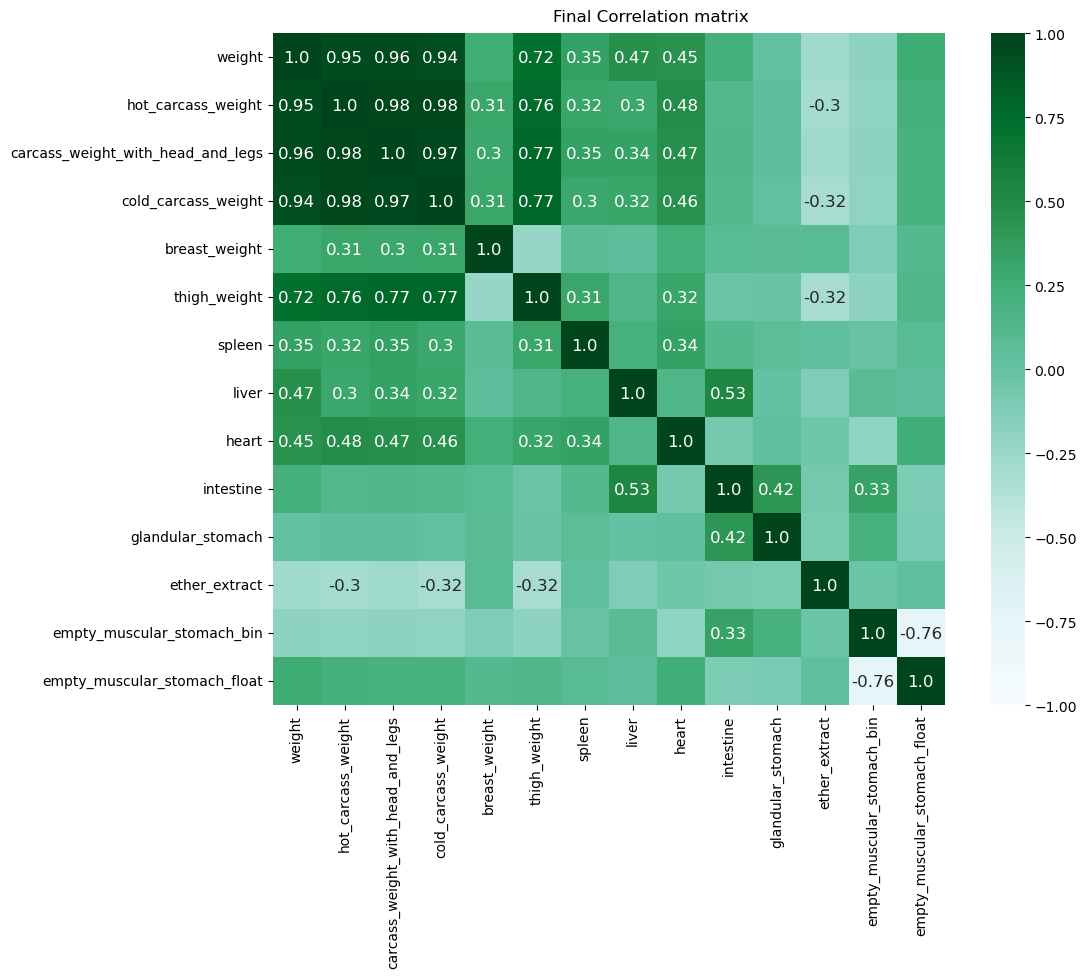

In [22]:
corr = df[features].corr().round(2)
fig = plt.figure(figsize=(12, 8))

# annotation matrix - values above |0.3| will appear in the plot
mask_annot = np.absolute(corr.values) >= 0.3
annot = np.where(mask_annot, corr.values, np.full(corr.shape, ''))
sns.heatmap(data = corr, annot = annot, cmap = 'BuGn', fmt = 's', vmin = -1, vmax = 1, center = 0, square = True, linewidths = 0, annot_kws = {'size': 12})

fig.subplots_adjust(top = 0.95)
fig.suptitle('Final Correlation matrix');

The correlation matrix reveals some strong linear relationships among various variables, which points to possible redundancy in the dataset:

- For example, weight, hot_carcass_weight, carcass_weight_with_head_and_legs, and cold_carcass_weight are all highly correlated with each other, with values ranging from 0.94 to 0.98, very high. This indicates that including all four in a model or analysis could lead to multicollinearity issues.

- So, to simplify, we might want to keep just one representative variable—like hot_carcass_weight—and leave the others out.

We are going to keep `empty_muscular_stomach_bin` since it has a better correlation witht the target.

In [23]:
df['empty_muscular_stomach'] = df['empty_muscular_stomach_bin'] 

In [24]:
df = df.drop(columns=['empty_muscular_stomach_float', 'empty_muscular_stomach_bin'])

`IMPORTANT:`the project description spcifically says "predict the crude protein weight using the remaining features in the dataset, excluding the animal ID." so we corrected the `empty_muscular_stomach` but we will not perform feature selection at this stage, basically we ll have this initial approach were we will test the models with all the features. If futher instructions state otherwise we will follow the analysis above.

In [25]:
scaler = RobustScaler()
scaled_values = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_values, columns=df.columns, index=df.index)

# Create interactive scatter plot
fig = go.Figure()

# Plot all features in light grey
for col in scaled_df.columns:
    if col != 'crude_protein':
        fig.add_trace(go.Scatter(
            x=scaled_df.index,
            y=scaled_df[col],
            mode='markers',
            marker=dict(color='lightgrey', size=6),
            name=col,
            text=[f'{col}: {val:.2f}' for val in scaled_df[col]],
            hoverinfo='text'
        ))

# Plot 'crude_protein' in green
fig.add_trace(go.Scatter(
    x=scaled_df.index,
    y=scaled_df['crude_protein'],
    mode='markers',
    marker=dict(color='green', size=7),
    name='crude_protein',
    text=[f'crude_protein: {val:.2f}' for val in scaled_df['crude_protein']],
    hoverinfo='text'
))

# Layout with scrollable x-axis
fig.update_layout(
    title='Robust Scaled Feature Values Across Index (Highlighting Crude Protein)',
    xaxis=dict(title='Index', rangeslider=dict(visible=True)),
    yaxis=dict(title='Scaled Value'),
    height=600,
    showlegend=False
)

fig.show()

We have two extreme cases that may potentially affect the results: V439 and V419. Cases like the G428 and B463 have a crude protein lower than the rest, but we can see that the variables like the ether_extract can accompany this variation. 

### <a id="method-selection"></a> 
<div style="background-color: hsla(120, 71.40%, 43.90%, 0.30); padding: 10px; border-radius: 8px; text-align: center; margin-top: 20px; margin-bottom: 20px;">
    <h3 style="color: white; margin: 0;">Choosing the method and parameters for each model</h3>
</div>

[Back to Index](#idx)

- [1. Nested cross-validation vs. Monte Carlo cross-validation](#method) 
- [2. Genetic Programming (GP)](#gp) - Delivery 1 (Done)
- [3. Geometric Semantic Geometric Programming (GSGP)](#gsgp) - Delivery 2 (Done)
- [4. Semantic Learning algorithm with Inflate and deflate Mutations (SLIM)](#slim) - Delivery 3 (Done)
- [5. Neural Network (NN)](#nn) - Delivery 4 (Done)
- [6. NeuroEvolution of Augmenting Topologies (NEAT)](#neat) - Delivery 4 (Done)

#### <a id="method"></a> 
<div style="background-color: hsla(120, 71.40%, 43.90%, 0.30); padding: 10px; border-radius: 8px; text-align: left; margin-top: 20px; margin-bottom: 20px;">
    <h4 style="color: white; margin: 0;">1. Nested cross-validation vs. Monte Carlo cross-validatio</h4>
</div>

[Back to Index](#idx)

In this project, we opted for **nested cross-validation (nested CV)** as our dataset partitioning strategy for both model selection (hyperparameter tuning) and performance evaluation.

This decision was based on the following considerations:

1. **Final Comparative Evaluation Across Algorithms**  
   At the end of the project, _"the same partitions should be used across all the algorithms to be studied"_, we will compare Genetic Programming (GP) and Geometric Semantic Genetic Programming (GSGP) and other machine learning algorithms.  
   To ensure a **fair and unbiased comparison**, the **same dataset partitions** must be used across all algorithms (are all evaluated under the same conditions basically) - Nested CV provides a systematic and reproducible way to maintain this consistency.

2. **Separation of Concerns: Tuning vs. Evaluation**  
   Nested CV explicitly separates the hyperparameter optimization (inner loop) from the model evaluation (outer loop).  
   This avoids **information leakage** and reduces the risk of **overfitting during model selection**, which is particularly relevant for algorithms like GP that are prone to overfitting and premature convergence.
   "the advantage of doing several iterations in cross-validation is that it allows us to obtain an error estimate that is not dependent on a single data splitting and a particular choice of the training data"_ (Vanneschi & Silva, Sec. 5.3, p.130). Nested CV extends this robustness by adding an inner loop for model selection, which further reduces the risk of biased or optimistic performance estimation.

3. **Avoiding Pitfalls of Monte Carlo CV in This Context**
   Although Monte Carlo cross-validation (or repeated random subsampling) can be viewd as an alternative (Vanneschi & Silva, p.130-131), it comes with a notable limitation: _"some observations may never be selected for the test set, while others will be selected more than once"_. In this project, where a **comparative and reproducible evaluation across multiple algorithms is required**, this irregularity makes Monte Carlo CV less appropriate than nested CV.  Using a **K-Fold outer loop** (e.g., `K=10`) ensures that every instance in the dataset is used for testing exactly once, and for training K-1 times, and combined with an **inner K-Fold** (e.g., `K=5`) for tuning, this strategy enables robust **statistical comparisons** (e.g., Wilcoxon tests, Friedman + Nemenyi post-hoc), which are essential to draw valid conclusions about performance differences between models.

   The  different CV strategies may be appropriate for different phases: _"it may make sense to use 5-fold or 10-fold cross-validation for choosing the method and parameters (...) and then use Monte Carlo (...) for a thorough estimation of the error"_ (p.131).  
   However, since our pipeline includes both tuning and evaluation as part of the **same CV process**, and comparison across methods is the final goal, we apply nested CV consistently for both.

4. Despite the relatively small size of our dataset (96 instances), we argue that nested cross-validation remains a justified choice. As pointed out by Vanneschi & Silva (Section 5.3), the reliability of performance estimation is a crucial concern when data is scarce. Nested CV is particularly effective in avoiding overfitting during hyperparameter tuning, which becomes even more critical under these circumstances.

The training and test sets generated in each fold still preserve enough data to fit and evaluate meaningful models. Moreover, since the dataset is small, the computational overhead introduced by nested CV is negligible.

In summary, while some may consider using Monte Carlo cross-validation to reduce computational cost or avoid small folds, the benefits of using nested cross-validation — particularly in terms of fair model selection and unbiased generalization error estimation — outweigh the drawbacks, especially when working with limited data.


In [26]:
target = 'crude_protein'
X = df.drop(columns=[target])
y = df[target]

In [27]:
k_outer = 5
k_inner = 3
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
outer_cv = KFold(n_splits=k_outer, shuffle=True, random_state=seed)
inner_cv = KFold(n_splits=k_inner, shuffle=True, random_state=seed)

total_instances = X.shape[0]
outer_test_size = total_instances // k_outer
outer_train_size = total_instances - outer_test_size
inner_val_size = outer_train_size // k_inner
inner_train_size = outer_train_size - inner_val_size

print(f'Total Instances:\t{total_instances}\n--')
print(f'Outer Train set:\t{outer_train_size}')
print(f'Test set:\t\t{outer_test_size}\n--')
print(f'Inner Train set:\t{inner_train_size}')
print(f'Validation set:\t\t{inner_val_size}\n')

Total Instances:	96
--
Outer Train set:	77
Test set:		19
--
Inner Train set:	52
Validation set:		25



- Dataset size: 96 samples -> GP can overfit easily on small data if trees get too big or the population too complex

In [35]:
# ===================== Nested CV Generator =====================
def nested_cv_generator(X, y, k_outer=10, k_inner=3, random_state=None):
    """ https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/"""
    outer_cv = KFold(n_splits=k_outer, shuffle=True, random_state=random_state)
    for outer_train_idx, outer_test_idx in outer_cv.split(X):
        X_outer_train = X.iloc[outer_train_idx].reset_index(drop=True)
        y_outer_train = y.iloc[outer_train_idx].reset_index(drop=True)
        X_test = X.iloc[outer_test_idx].reset_index(drop=True)
        y_test = y.iloc[outer_test_idx].reset_index(drop=True)

        inner_cv = KFold(n_splits=k_inner, shuffle=True, random_state=random_state)
        inner_splits = list(inner_cv.split(X_outer_train))

        yield {
            'X_outer_train': X_outer_train,
            'y_outer_train': y_outer_train,
            'X_test': X_test,
            'y_test': y_test,
            'inner_splits': inner_splits,
        }

In [28]:
from nested_cv import nested_cv_gp_slim_gsgp

In [36]:
# ========== Safe Inverse Transform ========== #
def safe_inverse_transform(scaler, y):
    if y.ndim == 1:
        y = y.reshape(-1, 1)
    return scaler.inverse_transform(y).flatten()

#### <a id="gp"></a> 
<div style="background-color: hsla(120, 71.40%, 43.90%, 0.30); padding: 10px; border-radius: 8px; text-align: left; margin-top: 20px; margin-bottom: 20px;">
    <h4 style="color: white; margin: 0;">2. Genetic Programming (GP)</h4>
</div>

[Back to Index](#idx)

| **Parameter**        | **Test Values**                                | **Why ??**                                                                                             |
| -------------------- | ----------------------------------------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------- |
| `init_depth`         | `[3, 5]`                                              | Smaller initial trees (shallow depth) reduce the risk of overfitting early on. With 96 entries, you want simplicity and better generalization.  |
| `max_depth`          | `[10]`                                             | Limits the model's complexity. Deep trees overfit easily on small datasets. Capping depth avoids bloated or overly specific programs.           |
| `tree_constants`     | `[random.uniform(0, 1) for _ in range(9)] + [-1.]`    | Constants allow models to fine-tune predictions. Using a limited, balanced range prevents excessive reliance on constants (avoids "bloat").     |
| `p_constants`        | `[0.1, 0.5]`                                          | High constant probability makes the tree more about constants than structure. This is dangerous for small data — prefer 10–20% range.           |
| `tree_functions`     | `['add', 'subtract', 'multiply', 'divide']` | Basic arithmetic gives expressive power. `protected_divide` avoids runtime errors. Don’t add too many functions — it increases search space.    |
| `pop_size`           | `[20, 30, 50]`                                        | Small datasets don’t need huge populations. Lower sizes = faster runs and still enough diversity. 20–50 is a good starting point.               |
| `p_xo`               | `[0.7, 0.9]`                                          | Crossover (recombination) promotes diversity and generalization. On small data, too much crossover (close to 1.0) might disrupt good solutions. |
| `initializer`        | `"grow", "rhh"`                                       | `grow` creates variable-sized trees. `rhh` mixes it with `full`, adding diversity. `full` alone — it tends to create deep, overfit trees. |
| `elitism`            | `[True]`                                              | Keep the best solution in each generation. With few samples, losing the best-performing individual can seriously hurt performance.              |
| `n_iter`             | `30`                                                  | Reasonable trade-off between computation and convergence. Too many iterations with small data can lead to overfitting.                          |


In [29]:
TREE_CONSTANTS = [random.uniform(0, 1) for _ in range(9)] + [-1.]
param_grid = {
    'initializer': ['grow', 'rhh'],
    'sspace.p_constants': [0.1, 0.5], 
    'sspace.max_init_depth': [3, 5],
    'sspace.max_depth': [10],
    'sspace.tree_constants': [TREE_CONSTANTS],
    'pop_size': [30, 50],
    'xo_prob': [0.7, 0.9],
    'generations': [30],
}

# Seeds to test
seeds = [42, 123, 456]  # You can change these to any seeds you prefer

# Store results from all seeds
all_scores = []
all_best_models = []
all_results = []
all_validation = []

for seed in seeds:
    print(f"\n=== Running with seed: {seed} ===\n")
    
    # Set random seeds for reproducibility
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    # Run the experiment
    scores, best_models, df_results, val_results = nested_cv_gp_slim_gsgp(
        X=X, y=y,
        param_grid=param_grid,
        gp_class=gp,
        k_outer=5, k_inner=3,
        seed=seed
    )
    
    # Store results
    all_scores.append(scores)
    all_best_models.append(best_models)
    all_results.append(df_results)
    all_validation.append(val_results)


=== Running with seed: 42 ===


========== OUTER FOLD 1/5 ==========


Grid Search:   0%|          | 0/32 [00:00<?, ?it/s]

Grid Search:   3%|▎         | 1/32 [00:00<00:15,  1.98it/s]

  Config 1/32 | Inner Mean RMSE: 1.8138


Grid Search:   6%|▋         | 2/32 [00:00<00:14,  2.02it/s]

  Config 2/32 | Inner Mean RMSE: 1.9002


Grid Search:   9%|▉         | 3/32 [00:01<00:19,  1.48it/s]

  Config 3/32 | Inner Mean RMSE: 1.6606


Grid Search:  12%|█▎        | 4/32 [00:02<00:16,  1.71it/s]

  Config 4/32 | Inner Mean RMSE: 1.9435


Grid Search:  16%|█▌        | 5/32 [00:02<00:15,  1.76it/s]

  Config 5/32 | Inner Mean RMSE: 1.9247


Grid Search:  19%|█▉        | 6/32 [00:03<00:12,  2.02it/s]

  Config 6/32 | Inner Mean RMSE: 127.2613


Grid Search:  22%|██▏       | 7/32 [00:04<00:21,  1.18it/s]

  Config 7/32 | Inner Mean RMSE: 2.0707


Grid Search:  25%|██▌       | 8/32 [00:05<00:17,  1.35it/s]

  Config 8/32 | Inner Mean RMSE: 1.9602


Grid Search:  28%|██▊       | 9/32 [00:05<00:14,  1.60it/s]

  Config 9/32 | Inner Mean RMSE: 1.8990


Grid Search:  31%|███▏      | 10/32 [00:05<00:11,  1.91it/s]

  Config 10/32 | Inner Mean RMSE: 1.9641


Grid Search:  34%|███▍      | 11/32 [00:06<00:12,  1.71it/s]

  Config 11/32 | Inner Mean RMSE: 1.8051


Grid Search:  38%|███▊      | 12/32 [00:07<00:10,  1.83it/s]

  Config 12/32 | Inner Mean RMSE: 2.0995


Grid Search:  41%|████      | 13/32 [00:07<00:09,  2.07it/s]

  Config 13/32 | Inner Mean RMSE: 1.9728


Grid Search:  44%|████▍     | 14/32 [00:07<00:07,  2.31it/s]

  Config 14/32 | Inner Mean RMSE: 1.7635


Grid Search:  47%|████▋     | 15/32 [00:08<00:08,  1.91it/s]

  Config 15/32 | Inner Mean RMSE: 1.6903


Grid Search:  50%|█████     | 16/32 [00:09<00:08,  1.99it/s]

  Config 16/32 | Inner Mean RMSE: 1.8365


Grid Search:  53%|█████▎    | 17/32 [00:09<00:07,  2.11it/s]

  Config 17/32 | Inner Mean RMSE: 2.0864


Grid Search:  56%|█████▋    | 18/32 [00:09<00:05,  2.43it/s]

  Config 18/32 | Inner Mean RMSE: 1.9380


Grid Search:  59%|█████▉    | 19/32 [00:10<00:07,  1.81it/s]

  Config 19/32 | Inner Mean RMSE: 1.7963


Grid Search:  62%|██████▎   | 20/32 [00:11<00:06,  1.84it/s]

  Config 20/32 | Inner Mean RMSE: 2.0338


Grid Search:  66%|██████▌   | 21/32 [00:11<00:06,  1.61it/s]

  Config 21/32 | Inner Mean RMSE: 1.7442


Grid Search:  69%|██████▉   | 22/32 [00:12<00:05,  1.84it/s]

  Config 22/32 | Inner Mean RMSE: 2.0495


Grid Search:  72%|███████▏  | 23/32 [00:13<00:07,  1.18it/s]

  Config 23/32 | Inner Mean RMSE: 1.8923


Grid Search:  75%|███████▌  | 24/32 [00:15<00:07,  1.03it/s]

  Config 24/32 | Inner Mean RMSE: 1.8894


Grid Search:  78%|███████▊  | 25/32 [00:15<00:05,  1.22it/s]

  Config 25/32 | Inner Mean RMSE: 1.6191


Grid Search:  81%|████████▏ | 26/32 [00:15<00:03,  1.52it/s]

  Config 26/32 | Inner Mean RMSE: 1.8350


Grid Search:  84%|████████▍ | 27/32 [00:16<00:03,  1.50it/s]

  Config 27/32 | Inner Mean RMSE: 1.6711


Grid Search:  88%|████████▊ | 28/32 [00:16<00:02,  1.63it/s]

  Config 28/32 | Inner Mean RMSE: 1.8741


Grid Search:  91%|█████████ | 29/32 [00:17<00:01,  1.79it/s]

  Config 29/32 | Inner Mean RMSE: 1.8580


Grid Search:  94%|█████████▍| 30/32 [00:17<00:01,  1.95it/s]

  Config 30/32 | Inner Mean RMSE: 2.3203


Grid Search:  97%|█████████▋| 31/32 [00:18<00:00,  1.69it/s]

  Config 31/32 | Inner Mean RMSE: 1.8503


Grid Search: 100%|██████████| 32/32 [00:19<00:00,  1.65it/s]

  Config 32/32 | Inner Mean RMSE: 1.8340

✅ Best config for outer fold 1:
{'initializer': 'rhh', 'sspace': {'p_constants': 0.5, 'max_init_depth': 3, 'tree_constants': [0.6394267984578837, 0.025010755222666936, 0.27502931836911926, 0.22321073814882275, 0.7364712141640124, 0.6766994874229113, 0.8921795677048454, 0.08693883262941615, 0.4219218196852704, -1.0], 'max_depth': 9}, 'pop_size': 30, 'generations': 30, 'seed': 42, 'original_config_id': 24, 'xo_prob': 0.7}
Best inner RMSE: 1.6191

Statistical test on inner fold scores:
Friedman test statistic: 33.3419, p-value: 0.3540
No significant differences found between configs.



[Outer Fold 1] Test RMSE: 1.7462

========== OUTER FOLD 2/5 ==========


Grid Search:   3%|▎         | 1/32 [00:00<00:15,  2.03it/s]

  Config 1/32 | Inner Mean RMSE: 2.9359


Grid Search:   6%|▋         | 2/32 [00:00<00:10,  2.74it/s]

  Config 2/32 | Inner Mean RMSE: 2.1495


Grid Search:   9%|▉         | 3/32 [00:01<00:16,  1.71it/s]

  Config 3/32 | Inner Mean RMSE: 2.7375


Grid Search:  12%|█▎        | 4/32 [00:02<00:16,  1.68it/s]

  Config 4/32 | Inner Mean RMSE: 4.5620


Grid Search:  16%|█▌        | 5/32 [00:02<00:16,  1.68it/s]

  Config 5/32 | Inner Mean RMSE: 4.7066


Grid Search:  19%|█▉        | 6/32 [00:03<00:13,  1.99it/s]

  Config 6/32 | Inner Mean RMSE: 2.8336


Grid Search:  22%|██▏       | 7/32 [00:04<00:18,  1.36it/s]

  Config 7/32 | Inner Mean RMSE: 9.0014


Grid Search:  25%|██▌       | 8/32 [00:05<00:17,  1.36it/s]

  Config 8/32 | Inner Mean RMSE: 2.3364


Grid Search:  28%|██▊       | 9/32 [00:05<00:15,  1.53it/s]

  Config 9/32 | Inner Mean RMSE: 1.9661


Grid Search:  31%|███▏      | 10/32 [00:05<00:11,  1.88it/s]

  Config 10/32 | Inner Mean RMSE: 2.0309


Grid Search:  34%|███▍      | 11/32 [00:06<00:11,  1.79it/s]

  Config 11/32 | Inner Mean RMSE: 1.5617


Grid Search:  38%|███▊      | 12/32 [00:06<00:10,  1.92it/s]

  Config 12/32 | Inner Mean RMSE: 1.7427


Grid Search:  41%|████      | 13/32 [00:07<00:09,  1.99it/s]

  Config 13/32 | Inner Mean RMSE: 2.1315


Grid Search:  44%|████▍     | 14/32 [00:07<00:08,  2.24it/s]

  Config 14/32 | Inner Mean RMSE: 4.6308


Grid Search:  47%|████▋     | 15/32 [00:08<00:08,  1.94it/s]

  Config 15/32 | Inner Mean RMSE: 2.1952


Grid Search:  50%|█████     | 16/32 [00:08<00:07,  2.01it/s]

  Config 16/32 | Inner Mean RMSE: 4.7529


Grid Search:  53%|█████▎    | 17/32 [00:09<00:07,  2.07it/s]

  Config 17/32 | Inner Mean RMSE: 5.2006


Grid Search:  56%|█████▋    | 18/32 [00:09<00:05,  2.43it/s]

  Config 18/32 | Inner Mean RMSE: 2.1538


Grid Search:  59%|█████▉    | 19/32 [00:10<00:07,  1.77it/s]

  Config 19/32 | Inner Mean RMSE: 2.9995


Grid Search:  62%|██████▎   | 20/32 [00:10<00:06,  1.86it/s]

  Config 20/32 | Inner Mean RMSE: 4.5747


Grid Search:  66%|██████▌   | 21/32 [00:11<00:06,  1.83it/s]

  Config 21/32 | Inner Mean RMSE: 1.7904


Grid Search:  69%|██████▉   | 22/32 [00:11<00:04,  2.08it/s]

  Config 22/32 | Inner Mean RMSE: 2.6570


Grid Search:  72%|███████▏  | 23/32 [00:12<00:05,  1.57it/s]

  Config 23/32 | Inner Mean RMSE: 2.3430


Grid Search:  75%|███████▌  | 24/32 [00:14<00:06,  1.21it/s]

  Config 24/32 | Inner Mean RMSE: 2.8379


Grid Search:  78%|███████▊  | 25/32 [00:14<00:04,  1.41it/s]

  Config 25/32 | Inner Mean RMSE: 2.2691


Grid Search:  81%|████████▏ | 26/32 [00:14<00:03,  1.74it/s]

  Config 26/32 | Inner Mean RMSE: 1.9767


Grid Search:  84%|████████▍ | 27/32 [00:15<00:03,  1.47it/s]

  Config 27/32 | Inner Mean RMSE: 1.7357


Grid Search:  88%|████████▊ | 28/32 [00:16<00:02,  1.61it/s]

  Config 28/32 | Inner Mean RMSE: 105.6324


Grid Search:  91%|█████████ | 29/32 [00:16<00:01,  1.81it/s]

  Config 29/32 | Inner Mean RMSE: 2.0237


Grid Search:  94%|█████████▍| 30/32 [00:16<00:00,  2.00it/s]

  Config 30/32 | Inner Mean RMSE: 2.1381


Grid Search:  97%|█████████▋| 31/32 [00:17<00:00,  1.66it/s]

  Config 31/32 | Inner Mean RMSE: 2.8456


Grid Search: 100%|██████████| 32/32 [00:19<00:00,  1.66it/s]

  Config 32/32 | Inner Mean RMSE: 2.0745

✅ Best config for outer fold 2:
{'initializer': 'grow', 'sspace': {'p_constants': 0.5, 'max_init_depth': 3, 'tree_constants': [0.6394267984578837, 0.025010755222666936, 0.27502931836911926, 0.22321073814882275, 0.7364712141640124, 0.6766994874229113, 0.8921795677048454, 0.08693883262941615, 0.4219218196852704, -1.0], 'max_depth': 9}, 'pop_size': 50, 'generations': 30, 'seed': 42, 'original_config_id': 10, 'xo_prob': 0.7}
Best inner RMSE: 1.5617

Statistical test on inner fold scores:
Friedman test statistic: 31.7983, p-value: 0.4266
No significant differences found between configs.



[Outer Fold 2] Test RMSE: 0.9602

========== OUTER FOLD 3/5 ==========


Grid Search:   3%|▎         | 1/32 [00:00<00:16,  1.84it/s]

  Config 1/32 | Inner Mean RMSE: 1.5310


Grid Search:   6%|▋         | 2/32 [00:00<00:12,  2.39it/s]

  Config 2/32 | Inner Mean RMSE: 1.6426


Grid Search:   9%|▉         | 3/32 [00:01<00:16,  1.71it/s]

  Config 3/32 | Inner Mean RMSE: 1.3737


Grid Search:  12%|█▎        | 4/32 [00:02<00:17,  1.64it/s]

  Config 4/32 | Inner Mean RMSE: 1.2539


Grid Search:  16%|█▌        | 5/32 [00:02<00:17,  1.56it/s]

  Config 5/32 | Inner Mean RMSE: 1.6655


Grid Search:  19%|█▉        | 6/32 [00:03<00:13,  1.93it/s]

  Config 6/32 | Inner Mean RMSE: 1.4006


Grid Search:  22%|██▏       | 7/32 [00:04<00:18,  1.32it/s]

  Config 7/32 | Inner Mean RMSE: 1.4314


Grid Search:  25%|██▌       | 8/32 [00:05<00:22,  1.08it/s]

  Config 8/32 | Inner Mean RMSE: 1.3920


Grid Search:  28%|██▊       | 9/32 [00:06<00:17,  1.31it/s]

  Config 9/32 | Inner Mean RMSE: 1.4767


Grid Search:  31%|███▏      | 10/32 [00:06<00:13,  1.63it/s]

  Config 10/32 | Inner Mean RMSE: 1.3665


Grid Search:  34%|███▍      | 11/32 [00:07<00:14,  1.47it/s]

  Config 11/32 | Inner Mean RMSE: 1.3548


Grid Search:  38%|███▊      | 12/32 [00:07<00:11,  1.68it/s]

  Config 12/32 | Inner Mean RMSE: 1.3878


Grid Search:  41%|████      | 13/32 [00:08<00:10,  1.82it/s]

  Config 13/32 | Inner Mean RMSE: 1.4635


Grid Search:  44%|████▍     | 14/32 [00:08<00:08,  2.12it/s]

  Config 14/32 | Inner Mean RMSE: 1.4029


Grid Search:  47%|████▋     | 15/32 [00:09<00:10,  1.57it/s]

  Config 15/32 | Inner Mean RMSE: 1.2365


Grid Search:  50%|█████     | 16/32 [00:10<00:09,  1.64it/s]

  Config 16/32 | Inner Mean RMSE: 1.4099


Grid Search:  53%|█████▎    | 17/32 [00:10<00:09,  1.65it/s]

  Config 17/32 | Inner Mean RMSE: 1.5195


Grid Search:  56%|█████▋    | 18/32 [00:10<00:07,  1.87it/s]

  Config 18/32 | Inner Mean RMSE: 1.3182


Grid Search:  59%|█████▉    | 19/32 [00:12<00:10,  1.28it/s]

  Config 19/32 | Inner Mean RMSE: 1.5893


Grid Search:  62%|██████▎   | 20/32 [00:13<00:09,  1.29it/s]

  Config 20/32 | Inner Mean RMSE: 1.3930


Grid Search:  66%|██████▌   | 21/32 [00:13<00:07,  1.38it/s]

  Config 21/32 | Inner Mean RMSE: 1.4227


Grid Search:  69%|██████▉   | 22/32 [00:14<00:06,  1.63it/s]

  Config 22/32 | Inner Mean RMSE: 1.2743


Grid Search:  72%|███████▏  | 23/32 [00:15<00:07,  1.27it/s]

  Config 23/32 | Inner Mean RMSE: 1.3958


Grid Search:  75%|███████▌  | 24/32 [00:16<00:07,  1.03it/s]

  Config 24/32 | Inner Mean RMSE: 1.3618


Grid Search:  78%|███████▊  | 25/32 [00:17<00:05,  1.21it/s]

  Config 25/32 | Inner Mean RMSE: 1.2758


Grid Search:  81%|████████▏ | 26/32 [00:17<00:04,  1.47it/s]

  Config 26/32 | Inner Mean RMSE: 1.5348


Grid Search:  84%|████████▍ | 27/32 [00:18<00:03,  1.36it/s]

  Config 27/32 | Inner Mean RMSE: 1.1056


Grid Search:  88%|████████▊ | 28/32 [00:18<00:02,  1.46it/s]

  Config 28/32 | Inner Mean RMSE: 1.3348


Grid Search:  91%|█████████ | 29/32 [00:19<00:01,  1.64it/s]

  Config 29/32 | Inner Mean RMSE: 1.5286


Grid Search:  94%|█████████▍| 30/32 [00:19<00:01,  1.94it/s]

  Config 30/32 | Inner Mean RMSE: 1.4043


Grid Search:  97%|█████████▋| 31/32 [00:20<00:00,  1.53it/s]

  Config 31/32 | Inner Mean RMSE: 1.2585


Grid Search: 100%|██████████| 32/32 [00:21<00:00,  1.50it/s]

  Config 32/32 | Inner Mean RMSE: 1.4732

✅ Best config for outer fold 3:
{'initializer': 'rhh', 'sspace': {'p_constants': 0.5, 'max_init_depth': 3, 'tree_constants': [0.6394267984578837, 0.025010755222666936, 0.27502931836911926, 0.22321073814882275, 0.7364712141640124, 0.6766994874229113, 0.8921795677048454, 0.08693883262941615, 0.4219218196852704, -1.0], 'max_depth': 9}, 'pop_size': 50, 'generations': 30, 'seed': 42, 'original_config_id': 26, 'xo_prob': 0.7}
Best inner RMSE: 1.1056

Statistical test on inner fold scores:
Friedman test statistic: 38.6208, p-value: 0.1632
No significant differences found between configs.



[Outer Fold 3] Test RMSE: 3.1134

========== OUTER FOLD 4/5 ==========


Grid Search:   3%|▎         | 1/32 [00:00<00:13,  2.23it/s]

  Config 1/32 | Inner Mean RMSE: 2.3203


Grid Search:   6%|▋         | 2/32 [00:00<00:10,  2.75it/s]

  Config 2/32 | Inner Mean RMSE: 1.8661


Grid Search:   9%|▉         | 3/32 [00:01<00:15,  1.82it/s]

  Config 3/32 | Inner Mean RMSE: 1.7349


Grid Search:  12%|█▎        | 4/32 [00:02<00:15,  1.83it/s]

  Config 4/32 | Inner Mean RMSE: 2.6639


Grid Search:  16%|█▌        | 5/32 [00:02<00:16,  1.65it/s]

  Config 5/32 | Inner Mean RMSE: 2.0049


Grid Search:  19%|█▉        | 6/32 [00:03<00:13,  1.99it/s]

  Config 6/32 | Inner Mean RMSE: 25.3312


Grid Search:  22%|██▏       | 7/32 [00:04<00:20,  1.20it/s]

  Config 7/32 | Inner Mean RMSE: 2.0997


Grid Search:  25%|██▌       | 8/32 [00:06<00:25,  1.05s/it]

  Config 8/32 | Inner Mean RMSE: 1.8510


Grid Search:  28%|██▊       | 9/32 [00:06<00:20,  1.13it/s]

  Config 9/32 | Inner Mean RMSE: 2.2404


Grid Search:  31%|███▏      | 10/32 [00:06<00:15,  1.43it/s]

  Config 10/32 | Inner Mean RMSE: 2.1789


Grid Search:  34%|███▍      | 11/32 [00:07<00:14,  1.47it/s]

  Config 11/32 | Inner Mean RMSE: 1.9708


Grid Search:  38%|███▊      | 12/32 [00:08<00:12,  1.58it/s]

  Config 12/32 | Inner Mean RMSE: 1.8843


Grid Search:  41%|████      | 13/32 [00:08<00:11,  1.64it/s]

  Config 13/32 | Inner Mean RMSE: 1.9363


Grid Search:  44%|████▍     | 14/32 [00:08<00:09,  1.93it/s]

  Config 14/32 | Inner Mean RMSE: 2.0007


Grid Search:  47%|████▋     | 15/32 [00:09<00:09,  1.81it/s]

  Config 15/32 | Inner Mean RMSE: 3.5108


Grid Search:  50%|█████     | 16/32 [00:10<00:08,  1.79it/s]

  Config 16/32 | Inner Mean RMSE: 2.0558


Grid Search:  53%|█████▎    | 17/32 [00:10<00:07,  1.90it/s]

  Config 17/32 | Inner Mean RMSE: 2.5559


Grid Search:  56%|█████▋    | 18/32 [00:10<00:06,  2.20it/s]

  Config 18/32 | Inner Mean RMSE: 1.8660


Grid Search:  59%|█████▉    | 19/32 [00:11<00:08,  1.59it/s]

  Config 19/32 | Inner Mean RMSE: 3.4199


Grid Search:  62%|██████▎   | 20/32 [00:12<00:06,  1.74it/s]

  Config 20/32 | Inner Mean RMSE: 2.1806


Grid Search:  66%|██████▌   | 21/32 [00:13<00:07,  1.45it/s]

  Config 21/32 | Inner Mean RMSE: 2.2439


Grid Search:  69%|██████▉   | 22/32 [00:13<00:05,  1.74it/s]

  Config 22/32 | Inner Mean RMSE: 2.1078


Grid Search:  72%|███████▏  | 23/32 [00:14<00:06,  1.34it/s]

  Config 23/32 | Inner Mean RMSE: 1.7629


Grid Search:  75%|███████▌  | 24/32 [00:15<00:06,  1.29it/s]

  Config 24/32 | Inner Mean RMSE: 1.9091


Grid Search:  78%|███████▊  | 25/32 [00:16<00:04,  1.43it/s]

  Config 25/32 | Inner Mean RMSE: 1.7068


Grid Search:  81%|████████▏ | 26/32 [00:16<00:03,  1.71it/s]

  Config 26/32 | Inner Mean RMSE: 1.7762


Grid Search:  84%|████████▍ | 27/32 [00:17<00:03,  1.46it/s]

  Config 27/32 | Inner Mean RMSE: 2.5427


Grid Search:  88%|████████▊ | 28/32 [00:17<00:02,  1.61it/s]

  Config 28/32 | Inner Mean RMSE: 1.9496


Grid Search:  91%|█████████ | 29/32 [00:18<00:01,  1.82it/s]

  Config 29/32 | Inner Mean RMSE: 1.9013


Grid Search:  94%|█████████▍| 30/32 [00:18<00:00,  2.10it/s]

  Config 30/32 | Inner Mean RMSE: 2.5396


Grid Search:  97%|█████████▋| 31/32 [00:19<00:00,  1.52it/s]

  Config 31/32 | Inner Mean RMSE: 1.7480


Grid Search: 100%|██████████| 32/32 [00:20<00:00,  1.56it/s]

  Config 32/32 | Inner Mean RMSE: 2.3021

✅ Best config for outer fold 4:
{'initializer': 'rhh', 'sspace': {'p_constants': 0.5, 'max_init_depth': 3, 'tree_constants': [0.6394267984578837, 0.025010755222666936, 0.27502931836911926, 0.22321073814882275, 0.7364712141640124, 0.6766994874229113, 0.8921795677048454, 0.08693883262941615, 0.4219218196852704, -1.0], 'max_depth': 9}, 'pop_size': 30, 'generations': 30, 'seed': 42, 'original_config_id': 24, 'xo_prob': 0.7}
Best inner RMSE: 1.7068

Statistical test on inner fold scores:
Friedman test statistic: 29.4618, p-value: 0.5452
No significant differences found between configs.



[Outer Fold 4] Test RMSE: 1.3064

========== OUTER FOLD 5/5 ==========


Grid Search:   3%|▎         | 1/32 [00:00<00:15,  2.01it/s]

  Config 1/32 | Inner Mean RMSE: 2.2261


Grid Search:   6%|▋         | 2/32 [00:00<00:12,  2.38it/s]

  Config 2/32 | Inner Mean RMSE: 2.3429


Grid Search:   9%|▉         | 3/32 [00:01<00:20,  1.43it/s]

  Config 3/32 | Inner Mean RMSE: 2.1650


Grid Search:  12%|█▎        | 4/32 [00:02<00:20,  1.36it/s]

  Config 4/32 | Inner Mean RMSE: 2.0549


Grid Search:  16%|█▌        | 5/32 [00:03<00:18,  1.47it/s]

  Config 5/32 | Inner Mean RMSE: 2.5234


Grid Search:  19%|█▉        | 6/32 [00:03<00:15,  1.71it/s]

  Config 6/32 | Inner Mean RMSE: 2.4382


Grid Search:  22%|██▏       | 7/32 [00:05<00:23,  1.04it/s]

  Config 7/32 | Inner Mean RMSE: 1.7138


Grid Search:  25%|██▌       | 8/32 [00:06<00:21,  1.14it/s]

  Config 8/32 | Inner Mean RMSE: 1.9972


Grid Search:  28%|██▊       | 9/32 [00:06<00:17,  1.31it/s]

  Config 9/32 | Inner Mean RMSE: 2.0847


Grid Search:  31%|███▏      | 10/32 [00:06<00:13,  1.62it/s]

  Config 10/32 | Inner Mean RMSE: 2.0335


Grid Search:  34%|███▍      | 11/32 [00:07<00:12,  1.62it/s]

  Config 11/32 | Inner Mean RMSE: 2.2321


Grid Search:  38%|███▊      | 12/32 [00:08<00:12,  1.62it/s]

  Config 12/32 | Inner Mean RMSE: 1.9510


Grid Search:  41%|████      | 13/32 [00:08<00:10,  1.75it/s]

  Config 13/32 | Inner Mean RMSE: 2.7528


Grid Search:  44%|████▍     | 14/32 [00:08<00:08,  2.05it/s]

  Config 14/32 | Inner Mean RMSE: 2.0915


Grid Search:  47%|████▋     | 15/32 [00:09<00:10,  1.68it/s]

  Config 15/32 | Inner Mean RMSE: 2.7975


Grid Search:  50%|█████     | 16/32 [00:10<00:09,  1.69it/s]

  Config 16/32 | Inner Mean RMSE: 1.7924


Grid Search:  53%|█████▎    | 17/32 [00:10<00:08,  1.80it/s]

  Config 17/32 | Inner Mean RMSE: 1.7109


Grid Search:  56%|█████▋    | 18/32 [00:11<00:06,  2.14it/s]

  Config 18/32 | Inner Mean RMSE: 1.9991


Grid Search:  59%|█████▉    | 19/32 [00:12<00:08,  1.45it/s]

  Config 19/32 | Inner Mean RMSE: 1.6787


Grid Search:  62%|██████▎   | 20/32 [00:12<00:07,  1.63it/s]

  Config 20/32 | Inner Mean RMSE: 2.3363


Grid Search:  66%|██████▌   | 21/32 [00:13<00:06,  1.59it/s]

  Config 21/32 | Inner Mean RMSE: 2.2007


Grid Search:  69%|██████▉   | 22/32 [00:13<00:05,  1.85it/s]

  Config 22/32 | Inner Mean RMSE: 1.9183


Grid Search:  72%|███████▏  | 23/32 [00:14<00:06,  1.44it/s]

  Config 23/32 | Inner Mean RMSE: 2.2321


Grid Search:  75%|███████▌  | 24/32 [00:16<00:07,  1.11it/s]

  Config 24/32 | Inner Mean RMSE: 2.2110


Grid Search:  78%|███████▊  | 25/32 [00:16<00:05,  1.30it/s]

  Config 25/32 | Inner Mean RMSE: 1.7425


Grid Search:  81%|████████▏ | 26/32 [00:16<00:03,  1.60it/s]

  Config 26/32 | Inner Mean RMSE: 2.1819


Grid Search:  84%|████████▍ | 27/32 [00:17<00:03,  1.34it/s]

  Config 27/32 | Inner Mean RMSE: 1.6808


Grid Search:  88%|████████▊ | 28/32 [00:18<00:02,  1.52it/s]

  Config 28/32 | Inner Mean RMSE: 2.0826


Grid Search:  91%|█████████ | 29/32 [00:19<00:02,  1.50it/s]

  Config 29/32 | Inner Mean RMSE: 2.8977


Grid Search:  94%|█████████▍| 30/32 [00:19<00:01,  1.76it/s]

  Config 30/32 | Inner Mean RMSE: 2.4980


Grid Search:  97%|█████████▋| 31/32 [00:20<00:00,  1.58it/s]

  Config 31/32 | Inner Mean RMSE: 2.5031


Grid Search: 100%|██████████| 32/32 [00:20<00:00,  1.54it/s]

  Config 32/32 | Inner Mean RMSE: 2.1305

✅ Best config for outer fold 5:
{'initializer': 'rhh', 'sspace': {'p_constants': 0.1, 'max_init_depth': 3, 'tree_constants': [0.6394267984578837, 0.025010755222666936, 0.27502931836911926, 0.22321073814882275, 0.7364712141640124, 0.6766994874229113, 0.8921795677048454, 0.08693883262941615, 0.4219218196852704, -1.0], 'max_depth': 9}, 'pop_size': 50, 'generations': 30, 'seed': 42, 'original_config_id': 18, 'xo_prob': 0.7}
Best inner RMSE: 1.6787

Statistical test on inner fold scores:
Friedman test statistic: 29.1203, p-value: 0.5630
No significant differences found between configs.



[Outer Fold 5] Test RMSE: 0.9113

=== Running with seed: 123 ===


========== OUTER FOLD 1/5 ==========


Grid Search:   3%|▎         | 1/32 [00:00<00:13,  2.37it/s]

  Config 1/32 | Inner Mean RMSE: 1.6301


Grid Search:   6%|▋         | 2/32 [00:00<00:11,  2.53it/s]

  Config 2/32 | Inner Mean RMSE: 1.6724


Grid Search:   9%|▉         | 3/32 [00:01<00:20,  1.44it/s]

  Config 3/32 | Inner Mean RMSE: 1.1352


Grid Search:  12%|█▎        | 4/32 [00:02<00:17,  1.59it/s]

  Config 4/32 | Inner Mean RMSE: 1.7340


Grid Search:  16%|█▌        | 5/32 [00:02<00:15,  1.74it/s]

  Config 5/32 | Inner Mean RMSE: 1.1164


Grid Search:  19%|█▉        | 6/32 [00:03<00:12,  2.02it/s]

  Config 6/32 | Inner Mean RMSE: 1.2982


Grid Search:  22%|██▏       | 7/32 [00:04<00:15,  1.63it/s]

  Config 7/32 | Inner Mean RMSE: 1.2681


Grid Search:  25%|██▌       | 8/32 [00:04<00:14,  1.64it/s]

  Config 8/32 | Inner Mean RMSE: 1.3451


Grid Search:  28%|██▊       | 9/32 [00:05<00:12,  1.80it/s]

  Config 9/32 | Inner Mean RMSE: 1.1799


Grid Search:  31%|███▏      | 10/32 [00:05<00:10,  2.11it/s]

  Config 10/32 | Inner Mean RMSE: 1.1839


Grid Search:  34%|███▍      | 11/32 [00:06<00:11,  1.81it/s]

  Config 11/32 | Inner Mean RMSE: 1.2333


Grid Search:  38%|███▊      | 12/32 [00:06<00:10,  1.89it/s]

  Config 12/32 | Inner Mean RMSE: 1.1931


Grid Search:  41%|████      | 13/32 [00:06<00:09,  2.04it/s]

  Config 13/32 | Inner Mean RMSE: 1.0924


Grid Search:  44%|████▍     | 14/32 [00:07<00:07,  2.33it/s]

  Config 14/32 | Inner Mean RMSE: 1.4102


Grid Search:  47%|████▋     | 15/32 [00:08<00:09,  1.83it/s]

  Config 15/32 | Inner Mean RMSE: 1.0982


Grid Search:  50%|█████     | 16/32 [00:08<00:08,  1.88it/s]

  Config 16/32 | Inner Mean RMSE: 1.1869


Grid Search:  53%|█████▎    | 17/32 [00:08<00:07,  2.04it/s]

  Config 17/32 | Inner Mean RMSE: 1.2585


Grid Search:  56%|█████▋    | 18/32 [00:09<00:06,  2.29it/s]

  Config 18/32 | Inner Mean RMSE: 1.2760


Grid Search:  59%|█████▉    | 19/32 [00:10<00:07,  1.63it/s]

  Config 19/32 | Inner Mean RMSE: 1.2126


Grid Search:  62%|██████▎   | 20/32 [00:10<00:06,  1.78it/s]

  Config 20/32 | Inner Mean RMSE: 1.1779


Grid Search:  66%|██████▌   | 21/32 [00:11<00:05,  1.85it/s]

  Config 21/32 | Inner Mean RMSE: 1.0755


Grid Search:  69%|██████▉   | 22/32 [00:11<00:04,  2.12it/s]

  Config 22/32 | Inner Mean RMSE: 1.2370


Grid Search:  72%|███████▏  | 23/32 [00:12<00:06,  1.42it/s]

  Config 23/32 | Inner Mean RMSE: 1.4521


Grid Search:  75%|███████▌  | 24/32 [00:13<00:05,  1.36it/s]

  Config 24/32 | Inner Mean RMSE: 1.1148


Grid Search:  78%|███████▊  | 25/32 [00:14<00:04,  1.58it/s]

  Config 25/32 | Inner Mean RMSE: 1.2281


Grid Search:  81%|████████▏ | 26/32 [00:14<00:03,  1.86it/s]

  Config 26/32 | Inner Mean RMSE: 1.2283


Grid Search:  84%|████████▍ | 27/32 [00:15<00:03,  1.57it/s]

  Config 27/32 | Inner Mean RMSE: 1.1470


Grid Search:  88%|████████▊ | 28/32 [00:15<00:02,  1.66it/s]

  Config 28/32 | Inner Mean RMSE: 1.2705


Grid Search:  91%|█████████ | 29/32 [00:16<00:01,  1.75it/s]

  Config 29/32 | Inner Mean RMSE: 1.1722


Grid Search:  94%|█████████▍| 30/32 [00:16<00:00,  2.03it/s]

  Config 30/32 | Inner Mean RMSE: 1.2813


Grid Search:  97%|█████████▋| 31/32 [00:17<00:00,  1.67it/s]

  Config 31/32 | Inner Mean RMSE: 1.2990


Grid Search: 100%|██████████| 32/32 [00:18<00:00,  1.74it/s]

  Config 32/32 | Inner Mean RMSE: 1.2868

✅ Best config for outer fold 1:
{'initializer': 'rhh', 'sspace': {'p_constants': 0.1, 'max_init_depth': 5, 'tree_constants': [0.6394267984578837, 0.025010755222666936, 0.27502931836911926, 0.22321073814882275, 0.7364712141640124, 0.6766994874229113, 0.8921795677048454, 0.08693883262941615, 0.4219218196852704, -1.0], 'max_depth': 11}, 'pop_size': 30, 'generations': 30, 'seed': 123, 'original_config_id': 20, 'xo_prob': 0.7}
Best inner RMSE: 1.0755

Statistical test on inner fold scores:
Friedman test statistic: 34.7924, p-value: 0.2921
No significant differences found between configs.



[Outer Fold 1] Test RMSE: 3.3285

========== OUTER FOLD 2/5 ==========


Grid Search:   3%|▎         | 1/32 [00:00<00:11,  2.63it/s]

  Config 1/32 | Inner Mean RMSE: 2.2790


Grid Search:   6%|▋         | 2/32 [00:00<00:11,  2.61it/s]

  Config 2/32 | Inner Mean RMSE: 2.3921


Grid Search:   9%|▉         | 3/32 [00:01<00:20,  1.45it/s]

  Config 3/32 | Inner Mean RMSE: 1.5899


Grid Search:  12%|█▎        | 4/32 [00:03<00:25,  1.10it/s]

  Config 4/32 | Inner Mean RMSE: 2.2463


Grid Search:  16%|█▌        | 5/32 [00:03<00:20,  1.31it/s]

  Config 5/32 | Inner Mean RMSE: 1.6731


Grid Search:  19%|█▉        | 6/32 [00:03<00:15,  1.68it/s]

  Config 6/32 | Inner Mean RMSE: 1.8066


Grid Search:  22%|██▏       | 7/32 [00:04<00:17,  1.41it/s]

  Config 7/32 | Inner Mean RMSE: 1.6955


Grid Search:  25%|██▌       | 8/32 [00:05<00:15,  1.57it/s]

  Config 8/32 | Inner Mean RMSE: 1.8879


Grid Search:  28%|██▊       | 9/32 [00:05<00:13,  1.66it/s]

  Config 9/32 | Inner Mean RMSE: 1.9492


Grid Search:  31%|███▏      | 10/32 [00:06<00:11,  1.92it/s]

  Config 10/32 | Inner Mean RMSE: 1.9062


Grid Search:  34%|███▍      | 11/32 [00:06<00:12,  1.62it/s]

  Config 11/32 | Inner Mean RMSE: 1.9827


Grid Search:  38%|███▊      | 12/32 [00:07<00:11,  1.74it/s]

  Config 12/32 | Inner Mean RMSE: 1.5699


Grid Search:  41%|████      | 13/32 [00:07<00:09,  1.93it/s]

  Config 13/32 | Inner Mean RMSE: 1.9017


Grid Search:  44%|████▍     | 14/32 [00:08<00:08,  2.18it/s]

  Config 14/32 | Inner Mean RMSE: 1.8138


Grid Search:  47%|████▋     | 15/32 [00:08<00:09,  1.80it/s]

  Config 15/32 | Inner Mean RMSE: 1.6771


Grid Search:  50%|█████     | 16/32 [00:09<00:08,  1.93it/s]

  Config 16/32 | Inner Mean RMSE: 1.8391


Grid Search:  53%|█████▎    | 17/32 [00:09<00:07,  2.02it/s]

  Config 17/32 | Inner Mean RMSE: 1.6989


Grid Search:  56%|█████▋    | 18/32 [00:10<00:06,  2.29it/s]

  Config 18/32 | Inner Mean RMSE: 1.7383


Grid Search:  59%|█████▉    | 19/32 [00:11<00:07,  1.73it/s]

  Config 19/32 | Inner Mean RMSE: 1.6866


Grid Search:  62%|██████▎   | 20/32 [00:11<00:07,  1.68it/s]

  Config 20/32 | Inner Mean RMSE: 2.2035


Grid Search:  66%|██████▌   | 21/32 [00:12<00:06,  1.75it/s]

  Config 21/32 | Inner Mean RMSE: 2.1816


Grid Search:  69%|██████▉   | 22/32 [00:12<00:04,  2.04it/s]

  Config 22/32 | Inner Mean RMSE: 2.3751


Grid Search:  72%|███████▏  | 23/32 [00:13<00:05,  1.65it/s]

  Config 23/32 | Inner Mean RMSE: 2.0562


Grid Search:  75%|███████▌  | 24/32 [00:14<00:05,  1.34it/s]

  Config 24/32 | Inner Mean RMSE: 1.6563


Grid Search:  78%|███████▊  | 25/32 [00:14<00:04,  1.56it/s]

  Config 25/32 | Inner Mean RMSE: 1.6390


Grid Search:  81%|████████▏ | 26/32 [00:15<00:03,  1.86it/s]

  Config 26/32 | Inner Mean RMSE: 1.8004


Grid Search:  84%|████████▍ | 27/32 [00:15<00:03,  1.65it/s]

  Config 27/32 | Inner Mean RMSE: 1.6075


Grid Search:  88%|████████▊ | 28/32 [00:16<00:02,  1.70it/s]

  Config 28/32 | Inner Mean RMSE: 1.7726


Grid Search:  91%|█████████ | 29/32 [00:17<00:01,  1.69it/s]

  Config 29/32 | Inner Mean RMSE: 1.7704


Grid Search:  94%|█████████▍| 30/32 [00:17<00:01,  1.83it/s]

  Config 30/32 | Inner Mean RMSE: 1.6815


Grid Search:  97%|█████████▋| 31/32 [00:18<00:00,  1.40it/s]

  Config 31/32 | Inner Mean RMSE: 1.6009


Grid Search: 100%|██████████| 32/32 [00:19<00:00,  1.67it/s]

  Config 32/32 | Inner Mean RMSE: 1.4864

✅ Best config for outer fold 2:
{'initializer': 'rhh', 'sspace': {'p_constants': 0.5, 'max_init_depth': 5, 'tree_constants': [0.6394267984578837, 0.025010755222666936, 0.27502931836911926, 0.22321073814882275, 0.7364712141640124, 0.6766994874229113, 0.8921795677048454, 0.08693883262941615, 0.4219218196852704, -1.0], 'max_depth': 11}, 'pop_size': 50, 'generations': 30, 'seed': 123, 'original_config_id': 31, 'xo_prob': 0.9}
Best inner RMSE: 1.4864

Statistical test on inner fold scores:
Friedman test statistic: 39.6397, p-value: 0.1374
No significant differences found between configs.



[Outer Fold 2] Test RMSE: 1.2020

========== OUTER FOLD 3/5 ==========


Grid Search:   3%|▎         | 1/32 [00:00<00:18,  1.65it/s]

  Config 1/32 | Inner Mean RMSE: 2.4292


Grid Search:   6%|▋         | 2/32 [00:00<00:12,  2.45it/s]

  Config 2/32 | Inner Mean RMSE: 1.8140


Grid Search:   9%|▉         | 3/32 [00:01<00:20,  1.43it/s]

  Config 3/32 | Inner Mean RMSE: 1.9040


Grid Search:  12%|█▎        | 4/32 [00:02<00:22,  1.26it/s]

  Config 4/32 | Inner Mean RMSE: 1.8554


Grid Search:  16%|█▌        | 5/32 [00:03<00:18,  1.47it/s]

  Config 5/32 | Inner Mean RMSE: 1.8206


Grid Search:  19%|█▉        | 6/32 [00:03<00:14,  1.80it/s]

  Config 6/32 | Inner Mean RMSE: 5.4287


Grid Search:  22%|██▏       | 7/32 [00:04<00:19,  1.27it/s]

  Config 7/32 | Inner Mean RMSE: 3.1044


Grid Search:  25%|██▌       | 8/32 [00:05<00:17,  1.40it/s]

  Config 8/32 | Inner Mean RMSE: 1.8092


Grid Search:  28%|██▊       | 9/32 [00:05<00:13,  1.65it/s]

  Config 9/32 | Inner Mean RMSE: 1.8220


Grid Search:  31%|███▏      | 10/32 [00:06<00:11,  1.98it/s]

  Config 10/32 | Inner Mean RMSE: 2.2359


Grid Search:  34%|███▍      | 11/32 [00:06<00:13,  1.61it/s]

  Config 11/32 | Inner Mean RMSE: 1.6318


Grid Search:  38%|███▊      | 12/32 [00:07<00:11,  1.70it/s]

  Config 12/32 | Inner Mean RMSE: 1.8854


Grid Search:  41%|████      | 13/32 [00:08<00:10,  1.74it/s]

  Config 13/32 | Inner Mean RMSE: 1.7931


Grid Search:  44%|████▍     | 14/32 [00:08<00:09,  1.99it/s]

  Config 14/32 | Inner Mean RMSE: 1.7347


Grid Search:  47%|████▋     | 15/32 [00:09<00:10,  1.55it/s]

  Config 15/32 | Inner Mean RMSE: 1.6243


Grid Search:  50%|█████     | 16/32 [00:09<00:09,  1.65it/s]

  Config 16/32 | Inner Mean RMSE: 1.8179


Grid Search:  53%|█████▎    | 17/32 [00:10<00:08,  1.70it/s]

  Config 17/32 | Inner Mean RMSE: 1.9362


Grid Search:  56%|█████▋    | 18/32 [00:10<00:07,  1.87it/s]

  Config 18/32 | Inner Mean RMSE: 1.9298


Grid Search:  59%|█████▉    | 19/32 [00:11<00:08,  1.60it/s]

  Config 19/32 | Inner Mean RMSE: 1.8212


Grid Search:  62%|██████▎   | 20/32 [00:12<00:06,  1.75it/s]

  Config 20/32 | Inner Mean RMSE: 1.9289


Grid Search:  66%|██████▌   | 21/32 [00:12<00:06,  1.63it/s]

  Config 21/32 | Inner Mean RMSE: 1.7003


Grid Search:  69%|██████▉   | 22/32 [00:13<00:05,  1.89it/s]

  Config 22/32 | Inner Mean RMSE: 1.9745


Grid Search:  72%|███████▏  | 23/32 [00:14<00:06,  1.30it/s]

  Config 23/32 | Inner Mean RMSE: 4.3784


Grid Search:  75%|███████▌  | 24/32 [00:15<00:06,  1.15it/s]

  Config 24/32 | Inner Mean RMSE: 3.0134


Grid Search:  78%|███████▊  | 25/32 [00:16<00:05,  1.27it/s]

  Config 25/32 | Inner Mean RMSE: 2.0611


Grid Search:  81%|████████▏ | 26/32 [00:16<00:03,  1.54it/s]

  Config 26/32 | Inner Mean RMSE: 1.8009


Grid Search:  84%|████████▍ | 27/32 [00:17<00:03,  1.40it/s]

  Config 27/32 | Inner Mean RMSE: 1.7073


Grid Search:  88%|████████▊ | 28/32 [00:18<00:03,  1.33it/s]

  Config 28/32 | Inner Mean RMSE: 2.2865


Grid Search:  91%|█████████ | 29/32 [00:18<00:02,  1.45it/s]

  Config 29/32 | Inner Mean RMSE: 3.7558


Grid Search:  94%|█████████▍| 30/32 [00:19<00:01,  1.60it/s]

  Config 30/32 | Inner Mean RMSE: 2.3921


Grid Search:  97%|█████████▋| 31/32 [00:20<00:00,  1.22it/s]

  Config 31/32 | Inner Mean RMSE: 1.5983


Grid Search: 100%|██████████| 32/32 [00:21<00:00,  1.52it/s]

  Config 32/32 | Inner Mean RMSE: 1.6538

✅ Best config for outer fold 3:
{'initializer': 'rhh', 'sspace': {'p_constants': 0.5, 'max_init_depth': 5, 'tree_constants': [0.6394267984578837, 0.025010755222666936, 0.27502931836911926, 0.22321073814882275, 0.7364712141640124, 0.6766994874229113, 0.8921795677048454, 0.08693883262941615, 0.4219218196852704, -1.0], 'max_depth': 11}, 'pop_size': 50, 'generations': 30, 'seed': 123, 'original_config_id': 30, 'xo_prob': 0.7}
Best inner RMSE: 1.5983

Statistical test on inner fold scores:
Friedman test statistic: 32.2762, p-value: 0.4035
No significant differences found between configs.



[Outer Fold 3] Test RMSE: 1.4820

========== OUTER FOLD 4/5 ==========


Grid Search:   3%|▎         | 1/32 [00:00<00:16,  1.90it/s]

  Config 1/32 | Inner Mean RMSE: 2.1242


Grid Search:   6%|▋         | 2/32 [00:00<00:11,  2.57it/s]

  Config 2/32 | Inner Mean RMSE: 2.3653


Grid Search:   9%|▉         | 3/32 [00:01<00:19,  1.50it/s]

  Config 3/32 | Inner Mean RMSE: 2.7055


Grid Search:  12%|█▎        | 4/32 [00:02<00:21,  1.28it/s]

  Config 4/32 | Inner Mean RMSE: 2.1613


Grid Search:  16%|█▌        | 5/32 [00:03<00:18,  1.48it/s]

  Config 5/32 | Inner Mean RMSE: 1.6306


Grid Search:  19%|█▉        | 6/32 [00:03<00:14,  1.81it/s]

  Config 6/32 | Inner Mean RMSE: 1.7552


Grid Search:  22%|██▏       | 7/32 [00:04<00:15,  1.58it/s]

  Config 7/32 | Inner Mean RMSE: 2.2876


Grid Search:  25%|██▌       | 8/32 [00:04<00:13,  1.74it/s]

  Config 8/32 | Inner Mean RMSE: 1.8310


Grid Search:  28%|██▊       | 9/32 [00:05<00:12,  1.78it/s]

  Config 9/32 | Inner Mean RMSE: 1.7525


Grid Search:  31%|███▏      | 10/32 [00:05<00:10,  2.09it/s]

  Config 10/32 | Inner Mean RMSE: 1.8994


Grid Search:  34%|███▍      | 11/32 [00:06<00:12,  1.70it/s]

  Config 11/32 | Inner Mean RMSE: 1.8315


Grid Search:  38%|███▊      | 12/32 [00:06<00:10,  1.82it/s]

  Config 12/32 | Inner Mean RMSE: 1.8033


Grid Search:  41%|████      | 13/32 [00:07<00:10,  1.81it/s]

  Config 13/32 | Inner Mean RMSE: 1.8563


Grid Search:  44%|████▍     | 14/32 [00:07<00:08,  2.13it/s]

  Config 14/32 | Inner Mean RMSE: 1.9773


Grid Search:  47%|████▋     | 15/32 [00:08<00:10,  1.69it/s]

  Config 15/32 | Inner Mean RMSE: 1.7032


Grid Search:  50%|█████     | 16/32 [00:09<00:09,  1.73it/s]

  Config 16/32 | Inner Mean RMSE: 2.1805


Grid Search:  53%|█████▎    | 17/32 [00:09<00:08,  1.82it/s]

  Config 17/32 | Inner Mean RMSE: 1.8397


Grid Search:  56%|█████▋    | 18/32 [00:10<00:06,  2.01it/s]

  Config 18/32 | Inner Mean RMSE: 2.3672


Grid Search:  59%|█████▉    | 19/32 [00:10<00:07,  1.63it/s]

  Config 19/32 | Inner Mean RMSE: 2.1041


Grid Search:  62%|██████▎   | 20/32 [00:11<00:06,  1.75it/s]

  Config 20/32 | Inner Mean RMSE: 2.2630


Grid Search:  66%|██████▌   | 21/32 [00:11<00:06,  1.80it/s]

  Config 21/32 | Inner Mean RMSE: 2.2958


Grid Search:  69%|██████▉   | 22/32 [00:12<00:05,  1.68it/s]

  Config 22/32 | Inner Mean RMSE: 2.2112


Grid Search:  72%|███████▏  | 23/32 [00:13<00:06,  1.29it/s]

  Config 23/32 | Inner Mean RMSE: 2.3171


Grid Search:  75%|███████▌  | 24/32 [00:14<00:06,  1.23it/s]

  Config 24/32 | Inner Mean RMSE: 3.6652


Grid Search:  78%|███████▊  | 25/32 [00:15<00:04,  1.43it/s]

  Config 25/32 | Inner Mean RMSE: 1.6200


Grid Search:  81%|████████▏ | 26/32 [00:15<00:03,  1.69it/s]

  Config 26/32 | Inner Mean RMSE: 1.8209


Grid Search:  84%|████████▍ | 27/32 [00:16<00:03,  1.48it/s]

  Config 27/32 | Inner Mean RMSE: 2.5967


Grid Search:  88%|████████▊ | 28/32 [00:16<00:02,  1.58it/s]

  Config 28/32 | Inner Mean RMSE: 2.1527


Grid Search:  91%|█████████ | 29/32 [00:17<00:01,  1.75it/s]

  Config 29/32 | Inner Mean RMSE: 1.7262


Grid Search:  94%|█████████▍| 30/32 [00:17<00:00,  2.02it/s]

  Config 30/32 | Inner Mean RMSE: 1.4650


Grid Search:  97%|█████████▋| 31/32 [00:18<00:00,  1.46it/s]

  Config 31/32 | Inner Mean RMSE: 2.2719


Grid Search: 100%|██████████| 32/32 [00:19<00:00,  1.65it/s]

  Config 32/32 | Inner Mean RMSE: 1.7788

✅ Best config for outer fold 4:
{'initializer': 'rhh', 'sspace': {'p_constants': 0.5, 'max_init_depth': 5, 'tree_constants': [0.6394267984578837, 0.025010755222666936, 0.27502931836911926, 0.22321073814882275, 0.7364712141640124, 0.6766994874229113, 0.8921795677048454, 0.08693883262941615, 0.4219218196852704, -1.0], 'max_depth': 11}, 'pop_size': 30, 'generations': 30, 'seed': 123, 'original_config_id': 29, 'xo_prob': 0.9}
Best inner RMSE: 1.4650

Statistical test on inner fold scores:
Friedman test statistic: 27.6233, p-value: 0.6405
No significant differences found between configs.



[Outer Fold 4] Test RMSE: 1.1321

========== OUTER FOLD 5/5 ==========


Grid Search:   3%|▎         | 1/32 [00:00<00:13,  2.22it/s]

  Config 1/32 | Inner Mean RMSE: 2.2357


Grid Search:   6%|▋         | 2/32 [00:00<00:10,  2.94it/s]

  Config 2/32 | Inner Mean RMSE: 2.2511


Grid Search:   9%|▉         | 3/32 [00:01<00:20,  1.44it/s]

  Config 3/32 | Inner Mean RMSE: 1.8939


Grid Search:  12%|█▎        | 4/32 [00:02<00:21,  1.31it/s]

  Config 4/32 | Inner Mean RMSE: 1.7107


Grid Search:  16%|█▌        | 5/32 [00:03<00:17,  1.51it/s]

  Config 5/32 | Inner Mean RMSE: 1.8382


Grid Search:  19%|█▉        | 6/32 [00:03<00:13,  1.88it/s]

  Config 6/32 | Inner Mean RMSE: 1.8751


Grid Search:  22%|██▏       | 7/32 [00:04<00:15,  1.64it/s]

  Config 7/32 | Inner Mean RMSE: 1.7563


Grid Search:  25%|██▌       | 8/32 [00:04<00:13,  1.81it/s]

  Config 8/32 | Inner Mean RMSE: 1.7519


Grid Search:  28%|██▊       | 9/32 [00:05<00:11,  1.96it/s]

  Config 9/32 | Inner Mean RMSE: 2.0096


Grid Search:  31%|███▏      | 10/32 [00:05<00:09,  2.27it/s]

  Config 10/32 | Inner Mean RMSE: 2.1406


Grid Search:  34%|███▍      | 11/32 [00:06<00:11,  1.87it/s]

  Config 11/32 | Inner Mean RMSE: 1.5296


Grid Search:  38%|███▊      | 12/32 [00:06<00:10,  1.99it/s]

  Config 12/32 | Inner Mean RMSE: 1.4760


Grid Search:  41%|████      | 13/32 [00:06<00:09,  2.05it/s]

  Config 13/32 | Inner Mean RMSE: 1.9876


Grid Search:  44%|████▍     | 14/32 [00:07<00:07,  2.31it/s]

  Config 14/32 | Inner Mean RMSE: 2.0429


Grid Search:  47%|████▋     | 15/32 [00:08<00:09,  1.89it/s]

  Config 15/32 | Inner Mean RMSE: 1.7368


Grid Search:  50%|█████     | 16/32 [00:08<00:08,  1.89it/s]

  Config 16/32 | Inner Mean RMSE: 1.9340


Grid Search:  53%|█████▎    | 17/32 [00:09<00:07,  1.90it/s]

  Config 17/32 | Inner Mean RMSE: 2.0431


Grid Search:  56%|█████▋    | 18/32 [00:09<00:06,  2.04it/s]

  Config 18/32 | Inner Mean RMSE: 41.9784


Grid Search:  59%|█████▉    | 19/32 [00:10<00:07,  1.81it/s]

  Config 19/32 | Inner Mean RMSE: 3.3561


Grid Search:  62%|██████▎   | 20/32 [00:10<00:06,  1.92it/s]

  Config 20/32 | Inner Mean RMSE: 2.1564


Grid Search:  66%|██████▌   | 21/32 [00:11<00:05,  2.01it/s]

  Config 21/32 | Inner Mean RMSE: 1.7326


Grid Search:  69%|██████▉   | 22/32 [00:11<00:04,  2.10it/s]

  Config 22/32 | Inner Mean RMSE: 6.0653


Grid Search:  72%|███████▏  | 23/32 [00:12<00:06,  1.44it/s]

  Config 23/32 | Inner Mean RMSE: 1.6138


Grid Search:  75%|███████▌  | 24/32 [00:13<00:05,  1.35it/s]

  Config 24/32 | Inner Mean RMSE: 1.8398


Grid Search:  78%|███████▊  | 25/32 [00:14<00:04,  1.50it/s]

  Config 25/32 | Inner Mean RMSE: 1.6373


Grid Search:  81%|████████▏ | 26/32 [00:14<00:03,  1.75it/s]

  Config 26/32 | Inner Mean RMSE: 1.9886


Grid Search:  84%|████████▍ | 27/32 [00:15<00:03,  1.38it/s]

  Config 27/32 | Inner Mean RMSE: 1.9992


Grid Search:  88%|████████▊ | 28/32 [00:15<00:02,  1.53it/s]

  Config 28/32 | Inner Mean RMSE: 2.1660


Grid Search:  91%|█████████ | 29/32 [00:16<00:02,  1.49it/s]

  Config 29/32 | Inner Mean RMSE: 1.5973


Grid Search:  94%|█████████▍| 30/32 [00:17<00:01,  1.60it/s]

  Config 30/32 | Inner Mean RMSE: 1.6328


Grid Search:  97%|█████████▋| 31/32 [00:18<00:00,  1.38it/s]

  Config 31/32 | Inner Mean RMSE: 2.2261


Grid Search: 100%|██████████| 32/32 [00:19<00:00,  1.62it/s]

  Config 32/32 | Inner Mean RMSE: 1.7117

✅ Best config for outer fold 5:
{'initializer': 'grow', 'sspace': {'p_constants': 0.5, 'max_init_depth': 3, 'tree_constants': [0.6394267984578837, 0.025010755222666936, 0.27502931836911926, 0.22321073814882275, 0.7364712141640124, 0.6766994874229113, 0.8921795677048454, 0.08693883262941615, 0.4219218196852704, -1.0], 'max_depth': 9}, 'pop_size': 50, 'generations': 30, 'seed': 123, 'original_config_id': 11, 'xo_prob': 0.9}
Best inner RMSE: 1.4760

Statistical test on inner fold scores:
Friedman test statistic: 36.2358, p-value: 0.2375
No significant differences found between configs.



[Outer Fold 5] Test RMSE: 1.6531

=== Running with seed: 456 ===


========== OUTER FOLD 1/5 ==========


Grid Search:   3%|▎         | 1/32 [00:00<00:13,  2.33it/s]

  Config 1/32 | Inner Mean RMSE: 1.4424


Grid Search:   6%|▋         | 2/32 [00:00<00:12,  2.50it/s]

  Config 2/32 | Inner Mean RMSE: 1.2677


Grid Search:   9%|▉         | 3/32 [00:01<00:18,  1.59it/s]

  Config 3/32 | Inner Mean RMSE: 1.4159


Grid Search:  12%|█▎        | 4/32 [00:02<00:17,  1.65it/s]

  Config 4/32 | Inner Mean RMSE: 1.0318


Grid Search:  16%|█▌        | 5/32 [00:02<00:16,  1.59it/s]

  Config 5/32 | Inner Mean RMSE: 1.1839


Grid Search:  19%|█▉        | 6/32 [00:03<00:14,  1.84it/s]

  Config 6/32 | Inner Mean RMSE: 1.2228


Grid Search:  22%|██▏       | 7/32 [00:04<00:21,  1.19it/s]

  Config 7/32 | Inner Mean RMSE: 1.8606


Grid Search:  25%|██▌       | 8/32 [00:05<00:19,  1.22it/s]

  Config 8/32 | Inner Mean RMSE: 1.5085


Grid Search:  28%|██▊       | 9/32 [00:06<00:16,  1.38it/s]

  Config 9/32 | Inner Mean RMSE: 1.0386


Grid Search:  31%|███▏      | 10/32 [00:06<00:13,  1.68it/s]

  Config 10/32 | Inner Mean RMSE: 0.9609


Grid Search:  34%|███▍      | 11/32 [00:07<00:13,  1.54it/s]

  Config 11/32 | Inner Mean RMSE: 0.9825


Grid Search:  38%|███▊      | 12/32 [00:07<00:11,  1.68it/s]

  Config 12/32 | Inner Mean RMSE: 0.9148


Grid Search:  41%|████      | 13/32 [00:08<00:10,  1.81it/s]

  Config 13/32 | Inner Mean RMSE: 0.9755


Grid Search:  44%|████▍     | 14/32 [00:08<00:08,  2.11it/s]

  Config 14/32 | Inner Mean RMSE: 1.4306


Grid Search:  47%|████▋     | 15/32 [00:09<00:09,  1.70it/s]

  Config 15/32 | Inner Mean RMSE: 1.0003


Grid Search:  50%|█████     | 16/32 [00:09<00:10,  1.58it/s]

  Config 16/32 | Inner Mean RMSE: 1.8797


Grid Search:  53%|█████▎    | 17/32 [00:10<00:09,  1.65it/s]

  Config 17/32 | Inner Mean RMSE: 0.9925


Grid Search:  56%|█████▋    | 18/32 [00:10<00:07,  1.92it/s]

  Config 18/32 | Inner Mean RMSE: 1.1388


Grid Search:  59%|█████▉    | 19/32 [00:11<00:08,  1.55it/s]

  Config 19/32 | Inner Mean RMSE: 0.9542


Grid Search:  62%|██████▎   | 20/32 [00:12<00:07,  1.57it/s]

  Config 20/32 | Inner Mean RMSE: 1.1175


Grid Search:  66%|██████▌   | 21/32 [00:12<00:06,  1.72it/s]

  Config 21/32 | Inner Mean RMSE: 3.1233


Grid Search:  69%|██████▉   | 22/32 [00:13<00:04,  2.00it/s]

  Config 22/32 | Inner Mean RMSE: 1.2270


Grid Search:  72%|███████▏  | 23/32 [00:14<00:05,  1.52it/s]

  Config 23/32 | Inner Mean RMSE: 1.1648


Grid Search:  75%|███████▌  | 24/32 [00:14<00:05,  1.53it/s]

  Config 24/32 | Inner Mean RMSE: 1.2197


Grid Search:  78%|███████▊  | 25/32 [00:15<00:04,  1.63it/s]

  Config 25/32 | Inner Mean RMSE: 0.9633


Grid Search:  81%|████████▏ | 26/32 [00:15<00:03,  1.93it/s]

  Config 26/32 | Inner Mean RMSE: 1.1884


Grid Search:  84%|████████▍ | 27/32 [00:16<00:02,  1.75it/s]

  Config 27/32 | Inner Mean RMSE: 1.0567


Grid Search:  88%|████████▊ | 28/32 [00:16<00:02,  1.82it/s]

  Config 28/32 | Inner Mean RMSE: 0.9932


Grid Search:  91%|█████████ | 29/32 [00:17<00:01,  1.99it/s]

  Config 29/32 | Inner Mean RMSE: 1.0091


Grid Search:  94%|█████████▍| 30/32 [00:17<00:00,  2.25it/s]

  Config 30/32 | Inner Mean RMSE: 1.2123


Grid Search:  97%|█████████▋| 31/32 [00:18<00:00,  1.72it/s]

  Config 31/32 | Inner Mean RMSE: 0.9752


Grid Search: 100%|██████████| 32/32 [00:19<00:00,  1.66it/s]

  Config 32/32 | Inner Mean RMSE: 0.9989

✅ Best config for outer fold 1:
{'initializer': 'grow', 'sspace': {'p_constants': 0.5, 'max_init_depth': 3, 'tree_constants': [0.6394267984578837, 0.025010755222666936, 0.27502931836911926, 0.22321073814882275, 0.7364712141640124, 0.6766994874229113, 0.8921795677048454, 0.08693883262941615, 0.4219218196852704, -1.0], 'max_depth': 9}, 'pop_size': 50, 'generations': 30, 'seed': 456, 'original_config_id': 11, 'xo_prob': 0.9}
Best inner RMSE: 0.9148

Statistical test on inner fold scores:
Friedman test statistic: 41.2849, p-value: 0.1025
No significant differences found between configs.



[Outer Fold 1] Test RMSE: 2.8469

========== OUTER FOLD 2/5 ==========


Grid Search:   3%|▎         | 1/32 [00:00<00:17,  1.79it/s]

  Config 1/32 | Inner Mean RMSE: 1.6983


Grid Search:   6%|▋         | 2/32 [00:00<00:12,  2.48it/s]

  Config 2/32 | Inner Mean RMSE: 2.0325


Grid Search:   9%|▉         | 3/32 [00:01<00:16,  1.78it/s]

  Config 3/32 | Inner Mean RMSE: 1.7349


Grid Search:  12%|█▎        | 4/32 [00:02<00:22,  1.25it/s]

  Config 4/32 | Inner Mean RMSE: 2.2755


Grid Search:  16%|█▌        | 5/32 [00:03<00:18,  1.43it/s]

  Config 5/32 | Inner Mean RMSE: 1.9356


Grid Search:  19%|█▉        | 6/32 [00:03<00:14,  1.78it/s]

  Config 6/32 | Inner Mean RMSE: 2.0659


Grid Search:  22%|██▏       | 7/32 [00:04<00:17,  1.41it/s]

  Config 7/32 | Inner Mean RMSE: 1.7476


Grid Search:  25%|██▌       | 8/32 [00:05<00:15,  1.55it/s]

  Config 8/32 | Inner Mean RMSE: 3.0802


Grid Search:  28%|██▊       | 9/32 [00:05<00:12,  1.79it/s]

  Config 9/32 | Inner Mean RMSE: 1.6993


Grid Search:  31%|███▏      | 10/32 [00:05<00:10,  2.06it/s]

  Config 10/32 | Inner Mean RMSE: 1.8066


Grid Search:  34%|███▍      | 11/32 [00:06<00:11,  1.81it/s]

  Config 11/32 | Inner Mean RMSE: 1.7092


Grid Search:  38%|███▊      | 12/32 [00:07<00:10,  1.86it/s]

  Config 12/32 | Inner Mean RMSE: 1.7710


Grid Search:  41%|████      | 13/32 [00:07<00:09,  2.00it/s]

  Config 13/32 | Inner Mean RMSE: 2.6685


Grid Search:  44%|████▍     | 14/32 [00:07<00:07,  2.30it/s]

  Config 14/32 | Inner Mean RMSE: 1.8178


Grid Search:  47%|████▋     | 15/32 [00:08<00:09,  1.75it/s]

  Config 15/32 | Inner Mean RMSE: 4.4537


Grid Search:  50%|█████     | 16/32 [00:09<00:09,  1.65it/s]

  Config 16/32 | Inner Mean RMSE: 3.2003


Grid Search:  53%|█████▎    | 17/32 [00:09<00:08,  1.74it/s]

  Config 17/32 | Inner Mean RMSE: 1.8907


Grid Search:  56%|█████▋    | 18/32 [00:10<00:07,  1.98it/s]

  Config 18/32 | Inner Mean RMSE: 1.9265


Grid Search:  59%|█████▉    | 19/32 [00:11<00:08,  1.62it/s]

  Config 19/32 | Inner Mean RMSE: 1.8443


Grid Search:  62%|██████▎   | 20/32 [00:11<00:07,  1.65it/s]

  Config 20/32 | Inner Mean RMSE: 1.8883


Grid Search:  66%|██████▌   | 21/32 [00:12<00:06,  1.72it/s]

  Config 21/32 | Inner Mean RMSE: 2.0841


Grid Search:  69%|██████▉   | 22/32 [00:12<00:05,  1.98it/s]

  Config 22/32 | Inner Mean RMSE: 3.8123


Grid Search:  72%|███████▏  | 23/32 [00:13<00:05,  1.60it/s]

  Config 23/32 | Inner Mean RMSE: 1.9355


Grid Search:  75%|███████▌  | 24/32 [00:13<00:04,  1.67it/s]

  Config 24/32 | Inner Mean RMSE: 1.9997


Grid Search:  78%|███████▊  | 25/32 [00:14<00:03,  1.87it/s]

  Config 25/32 | Inner Mean RMSE: 1.7847


Grid Search:  81%|████████▏ | 26/32 [00:14<00:02,  2.16it/s]

  Config 26/32 | Inner Mean RMSE: 1.7389


Grid Search:  84%|████████▍ | 27/32 [00:15<00:02,  1.92it/s]

  Config 27/32 | Inner Mean RMSE: 1.5956


Grid Search:  88%|████████▊ | 28/32 [00:15<00:02,  1.89it/s]

  Config 28/32 | Inner Mean RMSE: 3.0884


Grid Search:  91%|█████████ | 29/32 [00:16<00:01,  1.76it/s]

  Config 29/32 | Inner Mean RMSE: 3.1696


Grid Search:  94%|█████████▍| 30/32 [00:16<00:01,  1.95it/s]

  Config 30/32 | Inner Mean RMSE: 1.8401


Grid Search:  97%|█████████▋| 31/32 [00:17<00:00,  1.51it/s]

  Config 31/32 | Inner Mean RMSE: 55.3421


Grid Search: 100%|██████████| 32/32 [00:18<00:00,  1.74it/s]

  Config 32/32 | Inner Mean RMSE: 1.7071

✅ Best config for outer fold 2:
{'initializer': 'rhh', 'sspace': {'p_constants': 0.5, 'max_init_depth': 3, 'tree_constants': [0.6394267984578837, 0.025010755222666936, 0.27502931836911926, 0.22321073814882275, 0.7364712141640124, 0.6766994874229113, 0.8921795677048454, 0.08693883262941615, 0.4219218196852704, -1.0], 'max_depth': 9}, 'pop_size': 50, 'generations': 30, 'seed': 456, 'original_config_id': 26, 'xo_prob': 0.7}
Best inner RMSE: 1.5956

Statistical test on inner fold scores:
Friedman test statistic: 32.1735, p-value: 0.4084
No significant differences found between configs.



[Outer Fold 2] Test RMSE: 0.7397

========== OUTER FOLD 3/5 ==========


Grid Search:   3%|▎         | 1/32 [00:00<00:14,  2.12it/s]

  Config 1/32 | Inner Mean RMSE: 1.7118


Grid Search:   6%|▋         | 2/32 [00:00<00:10,  2.85it/s]

  Config 2/32 | Inner Mean RMSE: 1.6095


Grid Search:   9%|▉         | 3/32 [00:01<00:16,  1.76it/s]

  Config 3/32 | Inner Mean RMSE: 1.5915


Grid Search:  12%|█▎        | 4/32 [00:02<00:15,  1.78it/s]

  Config 4/32 | Inner Mean RMSE: 1.5890


Grid Search:  16%|█▌        | 5/32 [00:02<00:14,  1.81it/s]

  Config 5/32 | Inner Mean RMSE: 1.7475


Grid Search:  19%|█▉        | 6/32 [00:02<00:12,  2.14it/s]

  Config 6/32 | Inner Mean RMSE: 1.9057


Grid Search:  22%|██▏       | 7/32 [00:03<00:14,  1.72it/s]

  Config 7/32 | Inner Mean RMSE: 1.7461


Grid Search:  25%|██▌       | 8/32 [00:04<00:14,  1.68it/s]

  Config 8/32 | Inner Mean RMSE: 1.7061


Grid Search:  28%|██▊       | 9/32 [00:04<00:13,  1.75it/s]

  Config 9/32 | Inner Mean RMSE: 1.4945


Grid Search:  31%|███▏      | 10/32 [00:05<00:10,  2.05it/s]

  Config 10/32 | Inner Mean RMSE: 1.3724


Grid Search:  34%|███▍      | 11/32 [00:05<00:11,  1.76it/s]

  Config 11/32 | Inner Mean RMSE: 1.6874


Grid Search:  38%|███▊      | 12/32 [00:06<00:10,  1.83it/s]

  Config 12/32 | Inner Mean RMSE: 1.4594


Grid Search:  41%|████      | 13/32 [00:06<00:09,  2.07it/s]

  Config 13/32 | Inner Mean RMSE: 1.5833


Grid Search:  44%|████▍     | 14/32 [00:07<00:07,  2.42it/s]

  Config 14/32 | Inner Mean RMSE: 1.9513


Grid Search:  47%|████▋     | 15/32 [00:07<00:08,  2.08it/s]

  Config 15/32 | Inner Mean RMSE: 1.5434


Grid Search:  50%|█████     | 16/32 [00:08<00:07,  2.15it/s]

  Config 16/32 | Inner Mean RMSE: 1.6254


Grid Search:  53%|█████▎    | 17/32 [00:08<00:07,  1.96it/s]

  Config 17/32 | Inner Mean RMSE: 1.6094


Grid Search:  56%|█████▋    | 18/32 [00:09<00:06,  2.22it/s]

  Config 18/32 | Inner Mean RMSE: 1.6239


Grid Search:  59%|█████▉    | 19/32 [00:09<00:07,  1.80it/s]

  Config 19/32 | Inner Mean RMSE: 2.0457


Grid Search:  62%|██████▎   | 20/32 [00:10<00:06,  1.79it/s]

  Config 20/32 | Inner Mean RMSE: 1.7000


Grid Search:  66%|██████▌   | 21/32 [00:10<00:05,  1.86it/s]

  Config 21/32 | Inner Mean RMSE: 1.8050


Grid Search:  69%|██████▉   | 22/32 [00:11<00:04,  2.13it/s]

  Config 22/32 | Inner Mean RMSE: 1.7710


Grid Search:  72%|███████▏  | 23/32 [00:11<00:04,  1.91it/s]

  Config 23/32 | Inner Mean RMSE: 1.6505


Grid Search:  75%|███████▌  | 24/32 [00:12<00:04,  1.99it/s]

  Config 24/32 | Inner Mean RMSE: 1.6755


Grid Search:  78%|███████▊  | 25/32 [00:12<00:03,  2.13it/s]

  Config 25/32 | Inner Mean RMSE: 1.4756


Grid Search:  81%|████████▏ | 26/32 [00:13<00:02,  2.36it/s]

  Config 26/32 | Inner Mean RMSE: 1.4920


Grid Search:  84%|████████▍ | 27/32 [00:13<00:02,  2.08it/s]

  Config 27/32 | Inner Mean RMSE: 2.1211


Grid Search:  88%|████████▊ | 28/32 [00:14<00:01,  2.04it/s]

  Config 28/32 | Inner Mean RMSE: 1.5693


Grid Search:  91%|█████████ | 29/32 [00:14<00:01,  2.01it/s]

  Config 29/32 | Inner Mean RMSE: 1.8343


Grid Search:  94%|█████████▍| 30/32 [00:14<00:00,  2.29it/s]

  Config 30/32 | Inner Mean RMSE: 1.8644


Grid Search:  97%|█████████▋| 31/32 [00:15<00:00,  1.76it/s]

  Config 31/32 | Inner Mean RMSE: 1.7130


Grid Search: 100%|██████████| 32/32 [00:16<00:00,  1.92it/s]

  Config 32/32 | Inner Mean RMSE: 1.5043

✅ Best config for outer fold 3:
{'initializer': 'grow', 'sspace': {'p_constants': 0.5, 'max_init_depth': 3, 'tree_constants': [0.6394267984578837, 0.025010755222666936, 0.27502931836911926, 0.22321073814882275, 0.7364712141640124, 0.6766994874229113, 0.8921795677048454, 0.08693883262941615, 0.4219218196852704, -1.0], 'max_depth': 9}, 'pop_size': 30, 'generations': 30, 'seed': 456, 'original_config_id': 9, 'xo_prob': 0.9}
Best inner RMSE: 1.3724

Statistical test on inner fold scores:
Friedman test statistic: 30.3093, p-value: 0.5014
No significant differences found between configs.



[Outer Fold 3] Test RMSE: 1.4339

========== OUTER FOLD 4/5 ==========


Grid Search:   3%|▎         | 1/32 [00:00<00:13,  2.29it/s]

  Config 1/32 | Inner Mean RMSE: 1.8153


Grid Search:   6%|▋         | 2/32 [00:00<00:10,  2.80it/s]

  Config 2/32 | Inner Mean RMSE: 2.5616


Grid Search:   9%|▉         | 3/32 [00:01<00:16,  1.72it/s]

  Config 3/32 | Inner Mean RMSE: 1.9432


Grid Search:  12%|█▎        | 4/32 [00:02<00:17,  1.63it/s]

  Config 4/32 | Inner Mean RMSE: 2.2089


Grid Search:  16%|█▌        | 5/32 [00:02<00:16,  1.66it/s]

  Config 5/32 | Inner Mean RMSE: 1.7939


Grid Search:  19%|█▉        | 6/32 [00:03<00:13,  1.96it/s]

  Config 6/32 | Inner Mean RMSE: 1.8956


Grid Search:  22%|██▏       | 7/32 [00:04<00:16,  1.50it/s]

  Config 7/32 | Inner Mean RMSE: 1.6358


Grid Search:  25%|██▌       | 8/32 [00:04<00:16,  1.47it/s]

  Config 8/32 | Inner Mean RMSE: 1.5529


Grid Search:  28%|██▊       | 9/32 [00:05<00:13,  1.71it/s]

  Config 9/32 | Inner Mean RMSE: 1.6574


Grid Search:  31%|███▏      | 10/32 [00:05<00:11,  1.99it/s]

  Config 10/32 | Inner Mean RMSE: 1.6289


Grid Search:  34%|███▍      | 11/32 [00:06<00:12,  1.75it/s]

  Config 11/32 | Inner Mean RMSE: 1.8217


Grid Search:  38%|███▊      | 12/32 [00:06<00:10,  1.83it/s]

  Config 12/32 | Inner Mean RMSE: 1.7590


Grid Search:  41%|████      | 13/32 [00:07<00:10,  1.89it/s]

  Config 13/32 | Inner Mean RMSE: 1.6802


Grid Search:  44%|████▍     | 14/32 [00:07<00:08,  2.20it/s]

  Config 14/32 | Inner Mean RMSE: 1.9187


Grid Search:  47%|████▋     | 15/32 [00:08<00:09,  1.86it/s]

  Config 15/32 | Inner Mean RMSE: 1.7408


Grid Search:  50%|█████     | 16/32 [00:08<00:08,  1.81it/s]

  Config 16/32 | Inner Mean RMSE: 2.3144


Grid Search:  53%|█████▎    | 17/32 [00:09<00:08,  1.84it/s]

  Config 17/32 | Inner Mean RMSE: 3.9731


Grid Search:  56%|█████▋    | 18/32 [00:09<00:06,  2.15it/s]

  Config 18/32 | Inner Mean RMSE: 2.6355


Grid Search:  59%|█████▉    | 19/32 [00:10<00:07,  1.72it/s]

  Config 19/32 | Inner Mean RMSE: 2.1753


Grid Search:  62%|██████▎   | 20/32 [00:11<00:07,  1.62it/s]

  Config 20/32 | Inner Mean RMSE: 2.6136


Grid Search:  66%|██████▌   | 21/32 [00:11<00:06,  1.83it/s]

  Config 21/32 | Inner Mean RMSE: 2.8528


Grid Search:  69%|██████▉   | 22/32 [00:11<00:04,  2.06it/s]

  Config 22/32 | Inner Mean RMSE: 2.3555


Grid Search:  72%|███████▏  | 23/32 [00:12<00:05,  1.62it/s]

  Config 23/32 | Inner Mean RMSE: 1.9797


Grid Search:  75%|███████▌  | 24/32 [00:13<00:04,  1.74it/s]

  Config 24/32 | Inner Mean RMSE: 2.5383


Grid Search:  78%|███████▊  | 25/32 [00:13<00:03,  1.87it/s]

  Config 25/32 | Inner Mean RMSE: 1.8976


Grid Search:  81%|████████▏ | 26/32 [00:14<00:02,  2.18it/s]

  Config 26/32 | Inner Mean RMSE: 4.6201


Grid Search:  84%|████████▍ | 27/32 [00:14<00:02,  1.91it/s]

  Config 27/32 | Inner Mean RMSE: 17.4007


Grid Search:  88%|████████▊ | 28/32 [00:15<00:02,  1.96it/s]

  Config 28/32 | Inner Mean RMSE: 2.4007


Grid Search:  91%|█████████ | 29/32 [00:15<00:01,  2.07it/s]

  Config 29/32 | Inner Mean RMSE: 1.8163


Grid Search:  94%|█████████▍| 30/32 [00:16<00:00,  2.19it/s]

  Config 30/32 | Inner Mean RMSE: 1.8739


Grid Search:  97%|█████████▋| 31/32 [00:17<00:00,  1.62it/s]

  Config 31/32 | Inner Mean RMSE: 1.9366


Grid Search: 100%|██████████| 32/32 [00:17<00:00,  1.80it/s]

  Config 32/32 | Inner Mean RMSE: 1.9596

✅ Best config for outer fold 4:
{'initializer': 'grow', 'sspace': {'p_constants': 0.1, 'max_init_depth': 5, 'tree_constants': [0.6394267984578837, 0.025010755222666936, 0.27502931836911926, 0.22321073814882275, 0.7364712141640124, 0.6766994874229113, 0.8921795677048454, 0.08693883262941615, 0.4219218196852704, -1.0], 'max_depth': 11}, 'pop_size': 50, 'generations': 30, 'seed': 456, 'original_config_id': 7, 'xo_prob': 0.9}
Best inner RMSE: 1.5529

Statistical test on inner fold scores:
Friedman test statistic: 46.9321, p-value: 0.0332
Friedman test was significant, but no significant pairwise differences found.



[Outer Fold 4] Test RMSE: 1.0933

========== OUTER FOLD 5/5 ==========


Grid Search:   3%|▎         | 1/32 [00:00<00:10,  2.90it/s]

  Config 1/32 | Inner Mean RMSE: 1.6201


Grid Search:   6%|▋         | 2/32 [00:00<00:09,  3.29it/s]

  Config 2/32 | Inner Mean RMSE: 1.7641


Grid Search:   9%|▉         | 3/32 [00:01<00:16,  1.73it/s]

  Config 3/32 | Inner Mean RMSE: 1.6947


Grid Search:  12%|█▎        | 4/32 [00:01<00:14,  1.90it/s]

  Config 4/32 | Inner Mean RMSE: 1.9147


Grid Search:  16%|█▌        | 5/32 [00:02<00:13,  1.99it/s]

  Config 5/32 | Inner Mean RMSE: 1.6539


Grid Search:  19%|█▉        | 6/32 [00:02<00:11,  2.29it/s]

  Config 6/32 | Inner Mean RMSE: 1.8868


Grid Search:  22%|██▏       | 7/32 [00:03<00:15,  1.64it/s]

  Config 7/32 | Inner Mean RMSE: 1.6289


Grid Search:  25%|██▌       | 8/32 [00:04<00:14,  1.71it/s]

  Config 8/32 | Inner Mean RMSE: 2.0930


Grid Search:  28%|██▊       | 9/32 [00:04<00:11,  1.95it/s]

  Config 9/32 | Inner Mean RMSE: 1.5482


Grid Search:  31%|███▏      | 10/32 [00:04<00:09,  2.25it/s]

  Config 10/32 | Inner Mean RMSE: 1.5129


Grid Search:  34%|███▍      | 11/32 [00:05<00:12,  1.71it/s]

  Config 11/32 | Inner Mean RMSE: 1.5869


Grid Search:  38%|███▊      | 12/32 [00:06<00:12,  1.67it/s]

  Config 12/32 | Inner Mean RMSE: 1.5597


Grid Search:  41%|████      | 13/32 [00:06<00:10,  1.81it/s]

  Config 13/32 | Inner Mean RMSE: 1.5678


Grid Search:  44%|████▍     | 14/32 [00:07<00:08,  2.09it/s]

  Config 14/32 | Inner Mean RMSE: 1.7651


Grid Search:  47%|████▋     | 15/32 [00:07<00:09,  1.74it/s]

  Config 15/32 | Inner Mean RMSE: 1.5278


Grid Search:  50%|█████     | 16/32 [00:08<00:09,  1.74it/s]

  Config 16/32 | Inner Mean RMSE: 1.8317


Grid Search:  53%|█████▎    | 17/32 [00:09<00:08,  1.84it/s]

  Config 17/32 | Inner Mean RMSE: 2.9643


Grid Search:  56%|█████▋    | 18/32 [00:09<00:06,  2.10it/s]

  Config 18/32 | Inner Mean RMSE: 1.9176


Grid Search:  59%|█████▉    | 19/32 [00:10<00:07,  1.79it/s]

  Config 19/32 | Inner Mean RMSE: 2.0152


Grid Search:  62%|██████▎   | 20/32 [00:10<00:06,  1.94it/s]

  Config 20/32 | Inner Mean RMSE: 1.8643


Grid Search:  66%|██████▌   | 21/32 [00:10<00:05,  2.00it/s]

  Config 21/32 | Inner Mean RMSE: 1.7173


Grid Search:  69%|██████▉   | 22/32 [00:11<00:04,  2.24it/s]

  Config 22/32 | Inner Mean RMSE: 1.8937


Grid Search:  72%|███████▏  | 23/32 [00:12<00:05,  1.63it/s]

  Config 23/32 | Inner Mean RMSE: 6.5722


Grid Search:  75%|███████▌  | 24/32 [00:12<00:04,  1.70it/s]

  Config 24/32 | Inner Mean RMSE: 1.7308


Grid Search:  78%|███████▊  | 25/32 [00:13<00:03,  1.88it/s]

  Config 25/32 | Inner Mean RMSE: 2.0389


Grid Search:  81%|████████▏ | 26/32 [00:13<00:02,  2.21it/s]

  Config 26/32 | Inner Mean RMSE: 1.7298


Grid Search:  84%|████████▍ | 27/32 [00:14<00:02,  1.87it/s]

  Config 27/32 | Inner Mean RMSE: 1.7393


Grid Search:  88%|████████▊ | 28/32 [00:14<00:02,  1.95it/s]

  Config 28/32 | Inner Mean RMSE: 1.6519


Grid Search:  91%|█████████ | 29/32 [00:15<00:01,  2.07it/s]

  Config 29/32 | Inner Mean RMSE: 1.9748


Grid Search:  94%|█████████▍| 30/32 [00:15<00:00,  2.20it/s]

  Config 30/32 | Inner Mean RMSE: 1.6563


Grid Search:  97%|█████████▋| 31/32 [00:16<00:00,  1.60it/s]

  Config 31/32 | Inner Mean RMSE: 1.5164


Grid Search: 100%|██████████| 32/32 [00:17<00:00,  1.87it/s]

  Config 32/32 | Inner Mean RMSE: 1.4815

✅ Best config for outer fold 5:
{'initializer': 'rhh', 'sspace': {'p_constants': 0.5, 'max_init_depth': 5, 'tree_constants': [0.6394267984578837, 0.025010755222666936, 0.27502931836911926, 0.22321073814882275, 0.7364712141640124, 0.6766994874229113, 0.8921795677048454, 0.08693883262941615, 0.4219218196852704, -1.0], 'max_depth': 11}, 'pop_size': 50, 'generations': 30, 'seed': 456, 'original_config_id': 31, 'xo_prob': 0.9}
Best inner RMSE: 1.4815

Statistical test on inner fold scores:
Friedman test statistic: 29.9096, p-value: 0.5220
No significant differences found between configs.



[Outer Fold 5] Test RMSE: 1.0503


Running the full CV 3 times with different seeds to mitigate randomness from GP (e.g., in init, selection, mutation), and get statistically more reliable average performance (like doing 30 folds total) -> common trick in evolutionary algorithms due to their stochastic nature.

In [30]:
def dict_to_hashable(d):
    def make_hashable(value):
        if isinstance(value, dict):
            return tuple(sorted((k, make_hashable(v)) for k, v in value.items()))
        elif isinstance(value, list):
            return tuple(make_hashable(x) for x in value)
        elif isinstance(value, set):
            return tuple(sorted(make_hashable(x) for x in value))
        else:
            return value
    
    return tuple(sorted((k, make_hashable(v)) for k, v in d.items()))

# Now process the results
mean_scores = np.mean([scores for scores in all_scores], axis=0)
std_scores = np.std([scores for scores in all_scores], axis=0)

try:
    all_configs_hashed = [dict_to_hashable(config) for seed_models in all_best_models for config in seed_models]
    config_counts = Counter(all_configs_hashed)
    
    if config_counts:
        most_common_config_hash = config_counts.most_common(1)[0][0]
        best_config = dict((k, dict(v) if isinstance(v, tuple) else v) 
                        for k, v in most_common_config_hash)
        
        print("\n=== Final Results ===")
        print(f"Mean RMSE across seeds: {np.mean(mean_scores):.4f} ± {np.mean(std_scores):.4f}")
        print("\nBest configuration found in most runs:")
        for k, v in best_config.items():
            if isinstance(v, dict):
                print(f"  {k}:")
                for sub_k, sub_v in v.items():
                    print(f"    {sub_k}: {sub_v}")
            else:
                print(f"  {k}: {v}")
    else:
        print("No valid configurations found in all_best_models")
except Exception as e:
    print(f"Error processing configurations: {str(e)}")


=== Final Results ===
Mean RMSE across seeds: 1.5999 ± 0.4093

Best configuration found in most runs:
  generations: 30
  initializer: rhh
  original_config_id: 24
  pop_size: 30
  seed: 42
  sspace:
    max_depth: 9
    max_init_depth: 3
    p_constants: 0.5
    tree_constants: (0.6394267984578837, 0.025010755222666936, 0.27502931836911926, 0.22321073814882275, 0.7364712141640124, 0.6766994874229113, 0.8921795677048454, 0.08693883262941615, 0.4219218196852704, -1.0)
  xo_prob: 0.7


> Running GP with Best Config  

In [32]:
# ========== Config from Best Run ==========
best_config = {
    'initializer': 'rhh',
    'prob_const': 0.5,
    'init_depth': 3,
    'max_depth': 9,
    'tree_constants': [
        0.6394267984578837, 0.025010755222666936, 0.27502931836911926,
        0.22321073814882275, 0.7364712141640124, 0.6766994874229113,
        0.8921795677048454, 0.08693883262941615, 0.4219218196852704, -1.0
    ],
    'pop_size': 30,
    'xo_prob': 0.7,
    'generations': 30,
    'seed': 42
}

In [33]:
def evaluate_gp_with_best_config(X, y, best_config, gp_class, k_outer=5, seed=42, verbose=True):
    
    outer_cv = KFold(n_splits=k_outer, shuffle=True, random_state=seed)
    outer_scores = []
    models = []

    for fold_idx, (train_idx, test_idx) in enumerate(outer_cv.split(X)):
        print(f"\n=== Outer Fold {fold_idx+1}/{k_outer} ===")

        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Scaling
        x_scaler = RobustScaler()
        y_scaler = RobustScaler()
        X_train_scaled = x_scaler.fit_transform(X_train)
        y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
        X_test_scaled = x_scaler.transform(X_test)
        y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

        X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
        X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

        model = gp_class(
            X_train=X_train_tensor, y_train=y_train_tensor,
            X_test=X_test_tensor, y_test=y_test_tensor,
            dataset_name="🐓 Chicken 🐓",
            fitness_function='rmse',
            minimization=True,
            initializer=best_config['initializer'],
            tree_constants=best_config['tree_constants'],
            tree_functions=['add', 'subtract', 'multiply', 'divide'],
            prob_const=best_config['prob_const'],
            init_depth=best_config['init_depth'],
            max_depth=best_config['max_depth'],
            pop_size=best_config['pop_size'],
            p_xo=best_config['xo_prob'],
            elitism=True,
            n_elites=1,
            tournament_size=2,
            n_iter=best_config['generations'],
            test_elite=True,
            log_level=2,
            log_path=f"./log/GP/fold_{fold_idx+1}.csv",
            verbose=1 if verbose else 0,
            n_jobs=1,
            seed=best_config['seed']
        )

        models.append(model)

        with torch.no_grad():
            y_pred_scaled = model.predict(X_test_tensor).numpy()
            y_pred_rescaled = safe_inverse_transform(y_scaler, y_pred_scaled)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred_rescaled))
        print(f'Predicted Values: {y_pred_rescaled}')
        print(f'Real Values: {y_test}')
        print(f"Fold {fold_idx+1} RMSE: {rmse:.4f}")
        outer_scores.append(rmse)

    print(f"\n✅ Final RMSE across {k_outer} folds: {np.mean(outer_scores):.4f} ± {np.std(outer_scores):.4f}")
    return outer_scores, models

In [37]:
outer_scores, models = evaluate_gp_with_best_config(X, y, best_config, gp_class=gp, k_outer=5)


=== Outer Fold 1/5 ===
Verbose Reporter
-----------------------------------------------------------------------------------------------------------------------------------------
|         Dataset         |  Generation  |     Train Fitness     |       Test Fitness       |        Timing          |      Nodes       |
-----------------------------------------------------------------------------------------------------------------------------------------
|     🐓 Chicken 🐓         |       0      |   0.9644272327423096  |   0.9780014753341675     |   0.003999233245849609 |      3           |
|     🐓 Chicken 🐓         |       1      |   0.9643716812133789  |   0.9237210750579834     |   0.0034770965576171875|      7           |
|     🐓 Chicken 🐓         |       2      |   0.9643716812133789  |   0.9237210750579834     |   0.0029973983764648438|      7           |
|     🐓 Chicken 🐓         |       3      |   0.9643716812133789  |   0.9237210750579834     |   0.0038225650787353516|      7      

In [69]:
import numpy as np

# Valores previstos (Predicted Values)
predicted = np.array([87.762184, 88.40986,  87.71013,  88.408745, 85.117226, 88.499756, 87.73643,
 83.28404,  88.58992,  88.24123,  87.643394, 88.67391, 88.58532 , 87.68262,
 88.40462,  87.82191 , 88.89714  ,87.83124 , 88.32409 ])

# Valores reais (Real Values)
real = np.array([86.143472,
86.416898,
86.836578,
88.966240,
84.750742,
87.265701,
88.209459,
84.674187,
88.437500,
87.127568,
87.966937,
88.721884,
89.077733,
88.608826,
88.430599,
88.636682,
88.909255,
88.725712,
88.507288])

# Cálculo do RMSE
def rmse(predicted, real):
    squared_errors = (predicted - real) ** 2
    mean_squared_error = np.mean(squared_errors)
    root_mean_squared_error = np.sqrt(mean_squared_error)
    return root_mean_squared_error

# Chamando a função e imprimindo o resultado
rmse_value = rmse(predicted, real)
print(f"RMSE: {rmse_value:.6f}")

RMSE: 0.901711


In [60]:
# Valores previstos (Predicted Values)
predicted = np.array([0.12594746, 0.48198357, 0.09733419, 0.48137417, -1.3280184, 0.5314014,
                      0.11179042, -2.3357422,  0.5809671, 0.38928565, 0.06065027, 0.6271367,
                      0.5784385, 0.08221108, 0.47910464, 0.15877871, 0.74985003, 0.16391116,
                      0.4348346 ])

# Valores reais (Real Values)
real = np.array([-0.76387775, -0.61357181, -0.38286851,  0.78783455, -1.52947985, -0.14697384,
  0.37182258, -1.57156332,  0.49717947, -0.22290713,  0.23850499,  0.65350899,
  0.84912403,  0.59135971,  0.4933861,   0.60667257,  0.7565093,  0.65561324,
  0.53554261])

# Cálculo do RMSE
def rmse(predicted, real):
    squared_errors = (predicted - real) ** 2
    mean_squared_error = np.mean(squared_errors)
    root_mean_squared_error = np.sqrt(mean_squared_error)
    return root_mean_squared_error

# Chamando a função e imprimindo o resultado
rmse_value = rmse(predicted, real)
print(f"RMSE: {rmse_value:.6f}")

RMSE: 0.495682


In [ ]:
for fold_idx, model in enumerate(models, start=1):
    print(f"\n=== Tree Representation (Fold {fold_idx}) ===")
    if hasattr(model, 'print_tree_representation'):
        model.print_tree_representation()  # Direct print if available
    else:
        # Fallback for unsupported methods
        print("No tree printing method found. Try manual inspection:")
        print("Model attributes:", [attr for attr in dir(model) if not attr.startswith('_')])

In [ ]:
LOG_DIR = "log/GP/"
folds = [pd.read_csv(f"{LOG_DIR}fold_{i}.csv", header=None) for i in range(1, 6)]

In [ ]:
COLUMN_NAMES = [
    "Algorithm",      # 0
    "Instance_ID",    # 1
    "Dataset",        # 2
    "Seed",           # 3
    "Generation",     # 4
    "Fitness",        # 5 (Train RMSE)
    "Running_time",   # 6
    "Population_nodes", # 7
    "Test_fitness",   # 8 (Test RMSE)
    "Elite_nodes",    # 9 (Tree size)
    "Niche_entropy",  # 10
    "SD_pop_fit",     # 11 (Fitness diversity)
    "Log_level"       # 12
]

# Load all folds with column names
folds = []
for i in range(1, 6):
    df = pd.read_csv(f"log/GP/fold_{i}.csv", header=None)
    df.columns = COLUMN_NAMES  # Assign column names
    folds.append(df)

In [ ]:
folds[0].head()
#folds[0]['Niche_entropy'].unique() --- always 0

In [ ]:
NUMERIC_COLS = ["Generation", "Fitness", "Running_time", "Population_nodes", 
                "Test_fitness", "Elite_nodes", "Niche_entropy", "SD_pop_fit"]
numeric_folds = [df[NUMERIC_COLS] for df in folds]

In [ ]:
numeric_folds[0].head()

In [ ]:
all_data = np.stack([df.values for df in numeric_folds])

#  mean and std across folds
mean = np.mean(all_data, axis=0)  
std = np.std(all_data, axis=0)
mean_df = pd.DataFrame(mean, columns=NUMERIC_COLS)
std_df = pd.DataFrame(std, columns=NUMERIC_COLS)

In [ ]:
fig = go.Figure()

# Train Fitness (mean ± std)
fig.add_trace(go.Scatter(
    x=mean_df["Generation"],
    y=mean_df["Fitness"],
    mode='lines',
    name='Train RMSE (mean)',
    line=dict(color='blue', width=2)
))
# Add std as a shaded region (light blue)
fig.add_trace(go.Scatter(
    x=mean_df["Generation"],
    y=mean_df["Fitness"] + std_df["Fitness"],
    mode='lines',
    line=dict(width=0),
    showlegend=False,
    fillcolor='rgba(0, 100, 255, 0.2)',
    fill='tonexty'
))
fig.add_trace(go.Scatter(
    x=mean_df["Generation"],
    y=mean_df["Fitness"] - std_df["Fitness"],
    mode='lines',
    line=dict(width=0),
    name='±1 std (Train)',
    fillcolor='rgba(0, 100, 255, 0.2)'
))

# Test Fitness (mean ± std)
fig.add_trace(go.Scatter(
    x=mean_df["Generation"],
    y=mean_df["Test_fitness"],
    mode='lines',
    name='Test RMSE (mean)',
    line=dict(color='red', width=2)
))
# Add std as a shaded region (light red)
fig.add_trace(go.Scatter(
    x=mean_df["Generation"],
    y=mean_df["Test_fitness"] + std_df["Test_fitness"],
    mode='lines',
    line=dict(width=0),
    showlegend=False,
    fillcolor='rgba(255, 50, 50, 0.2)',
    fill='tonexty'
))
fig.add_trace(go.Scatter(
    x=mean_df["Generation"],
    y=mean_df["Test_fitness"] - std_df["Test_fitness"],
    mode='lines',
    line=dict(width=0),
    name='±1 std (Test)',
    fillcolor='rgba(255, 50, 50, 0.2)'
))

fig.update_layout(
    title=f'GP Fitness Evolution (Chicken Datset, 5-fold mean ± std)',
    xaxis_title='Generation',
    yaxis_title='RMSE',
    hovermode='x unified',
    height=400,
    width=800
)
fig.show()

In [ ]:
fig = go.Figure()

# Mean Size (Elite_nodes)
fig.add_trace(go.Scatter(
    x=mean_df["Generation"],
    y=mean_df["Elite_nodes"],
    mode='lines',
    name='Size (mean)',
    line=dict(color='green', width=2)
))

# Std as shaded region (light green)
fig.add_trace(go.Scatter(
    x=mean_df["Generation"],
    y=mean_df["Elite_nodes"] + std_df["Elite_nodes"],
    mode='lines',
    line=dict(width=0),
    showlegend=False,
    fillcolor='rgba(50, 200, 50, 0.2)',
    fill='tonexty'
))
fig.add_trace(go.Scatter(
    x=mean_df["Generation"],
    y=mean_df["Elite_nodes"] - std_df["Elite_nodes"],
    mode='lines',
    line=dict(width=0),
    name='±1 std',
    fillcolor='rgba(50, 200, 50, 0.2)'
))

fig.update_layout(
    title=f'GP - Size Evolution (Chicken Dataset, 5-fold mean ± std)',
    xaxis_title='Generation',
    yaxis_title='Number of Nodes',
    yaxis_range=[0, None],  # Start y-axis at 0
    height=400,
    width=800,
    margin=dict(t=50),
    hovermode='x unified'
)
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=mean_df["Generation"],
    y=mean_df["Niche_entropy"],
    mode='lines',
    name='Niche Entropy (mean)',
    line=dict(color='purple', width=2)
))
# Add std as dashed lines (dark purple)
fig.add_trace(go.Scatter(
    x=mean_df["Generation"],
    y=mean_df["Niche_entropy"] + std_df["Niche_entropy"],
    mode='lines',
    line=dict(color='purple', width=1, dash='dash'),
    name='+1 std',
    opacity=0.6
))
fig.add_trace(go.Scatter(
    x=mean_df["Generation"],
    y=mean_df["Niche_entropy"] - std_df["Niche_entropy"],
    mode='lines',
    line=dict(color='purple', width=1, dash='dash'),
    name='-1 std',
    opacity=0.6
))

fig.update_layout(
    title=f'GP - Niche Entropy (Chicken Dataset, 5-fold mean)',
    xaxis_title='Generation',
    yaxis_title='Entropy',
    yaxis_range=[0, None],
    height=400,
    width=800,
    margin=dict(t=50)
)
fig.show()

Although the best-performing configuration was found after the tuning, we ended up testing it again this time with the verbose parameter so we can analyze the generations across folds more in depth - we used the **5-fold outer cross-validation** to get am unbiased estimate of how well the model would perform on completely unseen data (as we explained before) -> Again, this helps avoid the trap of getting overly optimistic results from a single lucky train-test split.

---

**Per fold Analysis: Overfitting, Bloat and Premature Convergence**

- **Outer Fold 1**

This fold showed some interesting early behavior. The algorithm converged too quickly, locking onto a solution by the second generation. Training fitness dropped from 1.03 to 0.94 right away, then had small variations for the rest of the 30 generations. That kind of 'stagnation' can mean the population lost diversity early on and didn’t explore better parts of the solution space.

There was also a hint of overfitting between generations 5 and 7—training error kept going down, but test error briefly spiked above 1.12. but in generation 10, both errors settled around 0.73, showing the model found a decently generalizable solution.

As for **bloat**, there wasn’t any. The tree sizes stayed small and consistent, growing from 5 to 7 nodes early on and holding steady -> That’s a good sign the model was penalizing complexity.


- **Outer Fold 2**

After the first generation, test fitness dropped and went around 0.4125.. by generation 11. We thibnk the model got stuck in a local minimum or converged too early, and the training fitness kept improving slightly, which again hints at some overfitting.

Tree size didn’t grow—it stayed at 5 nodes during the plateau—so the model didn’t try to increase complexity to escape the stagnation. Still, it predicted reasonably well overall, with a final RMSE of 0.8379, which isn’t bad.


- **Outer Fold 3**

This one struggled, the training fitness got better (0.7010), the test fitness stayed high—around 1.6185. This shows overfitting as the model learned the training data but failed to generalize at all. On top of that, bloat became a problem bc the trees ballooned to 29 nodes by the end, the model added to much complexity and that extra complexity didn’t help. 

Outliers in the test data, like a very low crude protein value of 73.84, probably made things worse. Since we used the robust scaler this should had helped. This extra complexity can also indicate that we have too much features and the model tries too hard to learn all the patterns, a feature selection can maybe imporve this.

- **Outer Fold 4**

This fold saw a consistent reduction in training and test fitness at the beginning, so the model was learning at first. Training error declined from 0.998 to 0.857 and test error declined from 0.77 to 0.52 from generation 0 to generation 5 wich is a positive indicators of convergence. But after generation 6 train fitness fell into a stagnation phase and test started to get worse stabilizing at gen 12.Again, this suggests premature convergence the population could have lost diversity or wasn't under evolutionary pressure to escape the local optima.

There is a faint sign of overfitting after generation 12 and the model still explores more extensive trees -> node size grows from 9 to 31, and this added complexity did not contribute to generalization as the test fitness actually get worse.5198. So this inconsistency among increased complexity and worsening test performance is evidence of mild overfitting.

In terms of Bloat is obviasly more severe in this case. The early trees were tiny (5–11 nodes), but the model tried a 49-node tree in generation 8, and then stuck with bloated 31-node trees for no improvement in fitness. So, bloat without benefit, more complexity, but not better performance.

- **Outer Fold 5**

This fold showed early convergence, with improvements in training / test fitness over several generations. From generation 0 to 3, test fitness dropped from 0.8197 to 0.5241. But from generation 6 onwards, the model actually ceased to get better altogether —> a sure indication of premature convergence.

Bloat was completely avoided here. The model continued to hold a very small 3-node tree from generation 1 to generation 30. Although this is excellent at controlling complexity, it is also indicative of lacking exploration, and the model might have only settled on very shallow solution that was "good enough" and never moved further beyond.

Overfitting was small, good generalization with no significant gap between training and testing fitness.



**Final notes for GP**: So this solution needs some improvment to generalize better and avoid overcomplicate the size of the solution, our best approach would be to perfom feature selecion to try to help the model not to focus in every patter and generalize better, at the same time avoiding multicollinearity and features that add noise moree noise than help to the prediction.

#### <a id="gsgp"></a> 
<div style="background-color: hsla(120, 71.40%, 43.90%, 0.30); padding: 10px; border-radius: 8px; text-align: left; margin-top: 20px; margin-bottom: 20px;">
    <h4 style="color: white; margin: 0;">3. Geometric Semantic Geometric Programming (GSGP)</h4>
</div>

[Back to Index](#idx)

> since this delivery i about GSGP we will keep this massive code in here to be easier to evaluate but in the final project we will do it in python file and import the function (if its ok of course) to make the notebook cleaner

| **Parameter**        | **Test Values**                                | **Why ??**                                                                                             |
| -------------------- | ----------------------------------------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------- |
| `init_depth`         | `[3, 5]`                                              | Smaller initial trees (shallow depth) reduce the risk of overfitting early on. With 96 entries, you want simplicity and better generalization.  |
| `tree_constants`     | `[random.uniform(0, 1) for _ in range(9)] + [-1.]`    | Constants allow models to fine-tune predictions. Using a limited, balanced range prevents excessive reliance on constants (avoids "bloat").     |
| `p_constants`        | `[0.1, 0.5]`                                          | High constant probability makes the tree more about constants than structure. This is dangerous for small data — prefer 10–20% range.           |
| `tree_functions`     | `['add', 'subtract', 'multiply', 'divide']` | Basic arithmetic gives expressive power. `protected_divide` avoids runtime errors. Don’t add too many functions — it increases search space.    |
| `pop_size`           | `[20, 30, 50]`                                        | Small datasets don’t need huge populations. Lower sizes = faster runs and still enough diversity. 20–50 is a good starting point.               |
| `p_xo`               | `[0.7, 0.9]`                                          | Crossover (recombination) promotes diversity and generalization. On small data, too much crossover (close to 1.0) might disrupt good solutions. |
| `initializer`        | `"grow", "rhh"`                                       | `grow` creates variable-sized trees. `rhh` mixes it with `full`, adding diversity. `full` alone — it tends to create deep, overfit trees. |
| `elitism`            | `[True]`                                              | Keep the best solution in each generation. With few samples, losing the best-performing individual can seriously hurt performance.              |
| `n_iter`             | `[10, 15]`                                                  | Has to be lower than in regular GP, given that there is no maximum depth GSGP tends to bloat very quickly                        |
| `reconstruct`             | `True`                                                  | GSGP requires this parameter to store the trees' structure to construct the new generation                        |

Running the full CV 3 times with different seeds to mitigate randomness from GP (e.g., in init, selection, mutation), and get statistically more reliable average performance (like doing 30 folds total) -> common trick in evolutionary algorithms due to their stochastic nature.

> GSGP best configuration

`Geral Notes:` We notice that using a large population size or a high number of iterations in GSGP lead to a significant bloating, doing some research lead to the conclusion that since its generation introduces new semantic components without reducing the complexity of the existing structure this is normal so to reduce the big node count we used a smaller initial population and generations. 

Also, like for GP, although the best-performing configuration was found after the tuning, we ended up testing it again this time with the verbose parameter so we can analyze the generations across folds more in depth - we used the **5-fold outer cross-validation** to get am unbiased estimate of how well the model would perform on completely unseen data (as we explained before) -> Again, this helps avoid the trap of getting overly optimistic results from a single lucky train-test split.

---

- **Outer Fold 1 and Outer Fold 2 (More bloat in this one beacause the model tried to excape local opt more than one time)**

This fold initially performed quite well, showing promise in the early generations, it converged on generation 9. But, at the beginning, from generation 0 to 3, the test fitness drooped from 0.94 → 0.62 and training fitness from 0.94 → 0.83, and then in generation 4, the model began to overfit → the training fitness kept decreasing, but the test fitness did increase a bit 0.62 → 0.78 → 0.75.This suggests the model failed to generalize better despite training improvements.

Bloat was significant but the gsgp model is also more prone to that, we did have imporvements with some adjustments we did during the tunning, specifically experimenting with poppulation and interaction sizes, but we can explore that further. The increased complexity started when the signs of overfitting appear so we conclude that the model tried to increase complexity to improve the test score but without benefit from it.

Basically the model found a good region early but lacked mechanisms to control complexity or escape local optima.

- **Outer Fold 3**

This was the worst-performing fold in terms of rmse  so far, like in gp this fols with the low test value of 73 usually leads to problems, in this case the model converged early in gen 4/5 and then started to increase complexity / bloat to try to escape this lcocal optima, in the end did imporve a little bit but the trade off btw complexity and and the score was not worthed.

Training fitness, on the other hand, kept improving (0.76 → 0.45), indicating overfitting.

- **Outer Fold 4**

Again, it converged early in generations 4/5 and like in the other folds it started to add complexity to escape this local opt leading it to bloat, it did converged again on generation 9 but the score is worse than in generation 5, and since the training kept decreasing we can conclude the existance of overfitting. 

In the end, this fold demonstrates one of the best trade-offs between accuracy and complexity.

- **Outer Fold 5**

Similar thing happen in this fold, but the model was able to escape the local optmia with the increased bloat.



#### <a id="slim"></a> 
<div style="background-color: hsla(120, 71.40%, 43.90%, 0.30); padding: 10px; border-radius: 8px; text-align: left; margin-top: 20px; margin-bottom: 20px;">
    <h4 style="color: white; margin: 0;">4. Semantic Learning algorithm with Inflate and deflate Mutations (SLIM)</h4>
</div>

[Back to Index](#idx)

We already talked abou the other parameters above but for slim specific parameters:

| **Parameter**  | **Test Values**                                                                | **Why?**                                                                                                                                    |
| -------------- | ------------------------------------------------------------------------------ | ------------------------------------------------------------------------------------------------------------------------------------------- |
| `slim_version` | `['SLIM+SIG2', 'SLIM+SIG1', 'SLIM+ABS', 'SLIM*SIG2', 'SLIM*SIG1', 'SLIM*ABS']` | These cover both the standard and modified variants of SLIM with different mutation strategies, giving a broad view of performance impacts. |
| `p_inflate`    | `0.5`                                                                          | A balanced value to give equal chances to inflate and deflate mutations, supporting diverse structural exploration.                         |
| `copy_parent`  | `True`, `False`                                                                | `True` helps preserve valid individuals when mutation fails (good for stability). `False` increases selection pressure by discarding them.  |




> We originally tested over 300 parameter combinations during the tuning phase. However, since re-running all of them would be extremely time-consuming, we narrowed the parameter space to include only the most promising configurations. For example, we found that using 20 generations consistently produced suboptimal results across all folds, so we excluded it. Also, an initial tree depth of 3 performed better than depth 5 that often led to higher and more inconsistent boxplot distributions. We also tested a population size of 30, but it didn't offer any advantage and was removed as well. The final set of parameters reflects those that showed more consistent and efficient performance (in this way is more manageable to run this notebook again for the evaluation).

> SLIM best configuration

we can see that the size stabilized after the gen 30. 

Like for GP and GSGP, although the best-performing configuration was found after the tuning, we ended up testing it again this time with the verbose parameter so we can analyze the generations across folds more in depth - we used the **5-fold outer cross-validation** to get am unbiased estimate of how well the model would perform on completely unseen data (as we explained before) -> Again, this helps avoid the trap of getting overly optimistic results from a single lucky train-test split.

---

- **Outer Fold 1**

The model tries to escape a local optima right after the generation 1, incresing the node count to 20, this lead to the increase of complexity without benefit in terms of test performance since, althought the train fitness kept decreasing, the test fitness gave us a hint of overfitting since it start increasing from 0.73 to 0.77, an later after a considerate bloat reaching 46 nodes it increased again when the model started o decrease the node count. The model gets stuck with no further improvement in test fitness and minimal changes in train fitness (at 0.7847) at generation 17, the node count stabilizes at 35 nodes, slightly lower than the peak we reffer but still significantly bloated compared to the starting point -> this plateau suggests early convergence and persistent overfitting. The fitness values remain constant for over 30 generations.

As an overfitting evidence, tthe predicted values clustered tightly around the central values ~82–89, while the real values had more spread from 82 to 91, showing a loss of nuance in prediction — again a sign the model over-learned patterns from training data and failed to generalize well.

The model found a moderately promising region by generation 3 but lacked mechanisms (like parsimony pressure or semantic simplification) to control bloat or escape its local optimum, and the small improvement in predictions in gen 17 did not justify the increasing complexity.


- **Outer Fold 2**

Similiar behaviour to fold 1 at the beginning, the model initially shows signs of overfitting early on, as it increases in complexity/ node count jumping from 5 to 31 by generation 13 without significant gains in test performance. After a brief improvement until generation 19, where test fitness reaches its best value, the model the model tries to escape this optima invreasing the complexity and enters a prolonged plateau with no further gains, in fact the worse performance is reached here, despite increasing complexity to 48 nodes. This extended stagnation over 15 generations shows a classic bloat and overfitting behavior, where additional structure only improves train fitness while test performance keps getting worse or has no improvements. It ended with a worse fitness when considering the test set.

- **Outer Fold 3**

This fold was very straightforward, at generation 14 it was able to reach the best test fitness with less complexity, but since it tried to escape the local optima it end up increasing the model complexity at generation 25, with a slight decrease in test fitness. So the early convergence made the model tried to escape the local minimum and this actually led to a decrease in generalization (overfitting sincce the trin score kept decreasing) and more complexity, wich is not good. This is also proven since we can see the predictions cannot reach the real value of 73 althought the predicted value was the lowest in this case (84).

- **Outer Fold 4**

Again, very similiar the model tries to escape the local optima after a early convergence at generation 5 -> 0.47, reaching the best test fitness at this stage with 33 nodes, althought the model is able to get back from the decrease in test fitness and increased bloating from generation 9 to 41, at generation 42 it goes back to 33 nodes but with a slightly higher rmse -> 0.49. the train fitness kept decreasing and converged on this same generation 42, indicating overfitting since the test did get worse from the local optima at the beginning.

- **Outer Fold 5**

This fold clearly illustrates the core issue with the model -> early convergence followed by unsuccessful attempts to escape a local optimum. After an initial phase where a decent test fitness is achieved with low complexity, the model begins to overfit, increasing node count significantly to improve training fitness while test performance stagnates or worsens. Despite stabilizing the node count in later generations, the model continues to focus on optimizing training fitness, which results in poor generalization. This persistent overfitting, combined with unnecessary bloat, mirrors the inefficiencies seen across the other folds.


**Final notes**: 

Across all five folds, the model consistently exhibits early convergence followed by attempts to escape local optima through increased complexity (bloat). These attempts often result in overfitting, where training fitness improves at the cost of test performance. The model lacks mechanisms to effectively regulate complexity, such as parsimony pressure or semantic guidance, leading to unnecessarily bloat with minimal or negative gains in generalization. Predictions tend to cluster narrowly around central values, failing to capture the full range of real outputs, another indicator of overfitting. The folds collectively show that while the model can initially identify promising regions of the search space, its inability to control bloat or maintain generalization ultimately limits its performance.

So this solution needs some improvment to generalize better and avoid improving the train fitness at the expense of the test fitness, our best approach would be to perfom feature selecion to try to help the model not to focus in every patter and generalize better, at the same time avoiding multicollinearity and features that add noise moree noise than help to the prediction. We tested with less generations and the problem still persisted. 

#### <a id="NN"></a> 
<div style="background-color: hsla(120, 71.40%, 43.90%, 0.30); padding: 10px; border-radius: 8px; text-align: left; margin-top: 20px; margin-bottom: 20px;">
    <h4 style="color: white; margin: 0;">5. Neural Network (NN)</h4>
</div>

[Back to Index](#idx)

>  4.1. Network architecture

NN with three **linear layers**:

- The first will upscale the 2 input layer nodes (2 features in the dataset) to 3 nodes.
- The second will upscale to 4 nodes.
- The third (output) will, then, downscale to 1 node.

Besides that, the **activation functions** should be:

- The ReLU function in the hidden layer, and
- The sigmoid function in the output layer.

> 4.2. Weights and bias initialization

For the weights and bias initialization, let's use methods that are already available in the PyTorch library. However, notice that you can easily implement your own initialization methods.

- Weights: let's use the Xavier Uniform Initialization method. It maintains the variance of the activations remain the same across the layers of the network.
- Bias: bias will be initializes with zeros.

> 4.3. Forward pass

This step sets how the linear combination of the inputs and weights of each layer should work and how the combination of the linear step should be combined with the activation functions:

>4.4. Training loop

Having defined the Neural Network topology, the initialization method, and the feedforward pass, the behavior of the backpropagation should be set in the training loop.

For that, Pytorch has some useful methods:

- The `backward()` method calculates the derivative of the Error in respect to the NN weights applying the chain rule for hidden neurons;
- The `step()` method updates the weights and bias based on the computed gradients.

- **Fold 1**: Loss decreases well in the firts 20 iteractions then to 0.7, showing good convergence.
- **Fold 2**: Loss drops from 1.4 to 0.8, good but slower convergence comparing to fold 1.
- **Fold 3**: Loss improves well in the firts 20 iteractions from 0.9 to 0.5, demonstrating good convergence.
- **Fold 4**: Loss declines from 1.2 to 0.8, but a very gradual convergence.
- **Fold 5**: Loss reduces from 1.3 to 0.8, showing consistent but slower convergence.


- Overall all folds show a decreasing trend pn the loss function, confirming the model is learning.

- folds (1, 3) converge faster: Fold 3: {'hidden_sizes': [4], 'learning_rate': 0.001, 'batch_size': 8, 'num_epochs': 100, 'optimizer': 'SGD'}. So this should be our ideal configuration.

Nevertheless, we will conduct a more in-depth analysis in the final report (adding some other vizualizations to help.)

#### <a id="NEAT"></a> 
<div style="background-color: hsla(120, 71.40%, 43.90%, 0.30); padding: 10px; border-radius: 8px; text-align: left; margin-top: 20px; margin-bottom: 20px;">
    <h4 style="color: white; margin: 0;">6. NeuroEvolution of Augmenting Topologies (NEAT)</h4>
</div>

[Back to Index](#idx)

In [28]:
# ========== Safe Inverse Transform ========== #
def safe_inverse_transform(scaler, y):
    if y.ndim == 1:
        y = y.reshape(-1, 1)
    return scaler.inverse_transform(y).flatten()

In [29]:
# ========== Utility Functions ========== #

def eval_rmse(net, X, y):
    '''
    Auxiliary funciton to evaluate the RMSE.
    '''
    fit = 0.
    for xi, xo in zip(X, y):
        output = net.activate(xi)
        fit += (output[0] - xo)**2
    # RMSE
    return (fit/y.shape[0])**.5

# ========== Nested CV with NEAT ========== #

def make_eval_genomes(X_train, y_train, X_val, y_val):
    def eval_genomes(genomes, config):
        for genome_id, genome in genomes:
            net = neat.nn.FeedForwardNetwork.create(genome, config)
            # Train fitness
            genome.fitness = -eval_rmse(net, X_train, y_train)
            # Validation fitness
            genome.fitness_val = -eval_rmse(net, X_val, y_val)
    return eval_genomes

def generate_neat_config(template_path, hyperparams, output_path):
    with open(template_path, 'r') as f:
        config_str = f.read()

    for key, value in hyperparams.items():
        config_str = config_str.replace(f"<{key}>", str(value))

    with open(output_path, 'w') as f:
        f.write(config_str)

In [30]:
def nested_cv_neat(
    X, y, param_grid, k_outer=5, k_inner=3, dataset_name="Dataset",
    neat_template_path="neat_template.ini", seed=42, alpha_sig=0.05,
):
    # Create directory first to fail early if there are permission issues
    os.makedirs(f"./log/NEAT/{dataset_name}/", exist_ok=True)

    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    outer_scores = []
    best_grid_models = []
    validation_results = []
    detailed_results = []

    keys, values = zip(*param_grid.items())
    param_combos = [dict(zip(keys, v)) for v in product(*values)]

    for fold_idx, fold_data in enumerate(nested_cv_generator(X, y, k_outer, k_inner, seed)):
        print(f"\n========== OUTER FOLD {fold_idx+1}/{k_outer} ==========")
        best_config = None
        best_val_score = float("inf")
        all_inner_fold_scores = []

        for config_id, flat_config in enumerate(param_combos):
            inner_fold_rmses = []

            for inner_fold_idx, (inner_train_idx, inner_val_idx) in enumerate(fold_data['inner_splits']):
                X_train = fold_data['X_outer_train'].iloc[inner_train_idx]
                y_train = fold_data['y_outer_train'].iloc[inner_train_idx]
                X_val = fold_data['X_outer_train'].iloc[inner_val_idx]
                y_val = fold_data['y_outer_train'].iloc[inner_val_idx]

                # Scale
                x_scaler = RobustScaler()
                y_scaler = RobustScaler()
                X_train_scaled = x_scaler.fit_transform(X_train)
                X_val_scaled = x_scaler.transform(X_val)
                y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
                y_val_scaled = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()

                # Generate NEAT config
                neat_config_path = f"./log/NEAT/{dataset_name}/config_fold{fold_idx}_config{config_id}.ini"
                generate_neat_config(neat_template_path, flat_config, neat_config_path)

                # Load config and evolve
                neat_config = neat.Config(
                    neat.DefaultGenome,
                    neat.DefaultReproduction,
                    neat.DefaultSpeciesSet,
                    neat.DefaultStagnation,
                    neat_config_path
                )

                eval_genomes = make_eval_genomes(X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled)
                p = neat.Population(neat_config)
                p.add_reporter(neat.StdOutReporter(False))
                p.add_reporter(neat.StatisticsReporter())
                winner = p.run(eval_genomes, flat_config.get("generations", 50))

                net = neat.nn.FeedForwardNetwork.create(winner, neat_config)
                val_rmse = eval_rmse(net, X_val_scaled, y_val_scaled)
                inner_fold_rmses.append(val_rmse)

                detailed_results.append({
                    'outer_fold': fold_idx + 1,
                    'inner_fold': inner_fold_idx + 1,
                    'config_id': config_id,
                    'config': str(flat_config),
                    'rmse': val_rmse,
                })

            avg_val_rmse = np.mean(inner_fold_rmses)
            all_inner_fold_scores.append(inner_fold_rmses)

            print(f"  Config {config_id+1}/{len(param_combos)} | Mean RMSE: {avg_val_rmse:.4f}")
            if avg_val_rmse < best_val_score:
                best_val_score = avg_val_rmse
                best_config = flat_config

        print(f"\n✅ Best config for outer fold {fold_idx+1}: {best_config}")
        print(f"Best inner RMSE: {best_val_score:.4f}")
        best_grid_models.append(best_config)
        df_inner_scores = pd.DataFrame(all_inner_fold_scores).T
        validation_results.append(df_inner_scores)

        # Statistical test
        if len(param_combos) > 1:  # Only perform if we have multiple configs to compare
            print("\nStatistical test on inner fold scores:")
            try:
                stat, p = friedmanchisquare(*[df_inner_scores[col] for col in df_inner_scores.columns])
                print(f"Friedman test statistic: {stat:.4f}, p-value: {p:.4f}")
                if p < alpha_sig:
                    posthoc_result = sp.posthoc_nemenyi_friedman(df_inner_scores.to_numpy())
                    significant_mask = posthoc_result < alpha_sig
                    if significant_mask.values.any():
                        sig_table = posthoc_result.where(significant_mask).dropna(how='all').dropna(axis=1, how='all')
                        print("\nSignificant pairwise differences (p < alpha):")
                        print(sig_table.round(4))
                    else:
                        print("Friedman significant, but no pairwise differences found.")
                else:
                    print("No significant differences between configs.")
            except Exception as e:
                print(f"Statistical test failed: {e}")

        # Retrain on full outer train set
        x_scaler = RobustScaler()
        y_scaler = RobustScaler()
        X_outer_train_scaled = x_scaler.fit_transform(fold_data['X_outer_train'])
        X_test_scaled = x_scaler.transform(fold_data['X_test'])
        y_outer_train_scaled = y_scaler.fit_transform(fold_data['y_outer_train'].values.reshape(-1, 1)).flatten()
        y_test_scaled = y_scaler.transform(fold_data['y_test'].values.reshape(-1, 1)).flatten()

        neat_config_path = f"./log/NEAT/{dataset_name}/best_config_fold{fold_idx}.ini"
        generate_neat_config(neat_template_path, best_config, neat_config_path)

        neat_config = neat.Config(
            neat.DefaultGenome,
            neat.DefaultReproduction,
            neat.DefaultSpeciesSet,
            neat.DefaultStagnation,
            neat_config_path
        )

        eval_genomes = make_eval_genomes(X_outer_train_scaled, y_outer_train_scaled, X_test_scaled, y_test_scaled)
        p = neat.Population(neat_config)
        p.add_reporter(neat.StdOutReporter(False))
        p.add_reporter(neat.StatisticsReporter())
        winner = p.run(eval_genomes, best_config.get("generations", 50))

        net = neat.nn.FeedForwardNetwork.create(winner, neat_config)
        test_rmse = eval_rmse(net, X_test_scaled, y_test_scaled)
        print(f"[Outer Fold {fold_idx+1}] Test RMSE: {test_rmse:.4f}")
        outer_scores.append(test_rmse)
        gc.collect()

    print(f"\n================ Final Results ================\nMean RMSE: {np.mean(outer_scores):.4f} ± {np.std(outer_scores):.4f}")
    df_all_results = pd.DataFrame(detailed_results)
    return np.array(outer_scores), best_grid_models, df_all_results, validation_results

In [31]:
param_grid = {
    'pop_size': [50, 100],
    'activation_default': ['relu', 'tanh']
}

In [32]:
neat_log_dir = "log/NEAT/🐔Chicken🐔/"
results_dir = os.path.join(neat_log_dir, "analysis_results")

In [33]:
def load_results():
    results_dir = "log/NEAT/🐔Chicken🐔/analysis_results/"
    df_results = pd.read_csv(os.path.join(results_dir, "detailed_results.csv"))
    with open(os.path.join(results_dir, "best_models.json"), "r") as f:
        best_models = json.load(f)
    outer_scores = pd.read_csv(os.path.join(results_dir, "outer_scores.csv"))
    with open(os.path.join(results_dir, "param_grid.json"), "r") as f:
        param_grid = json.load(f)
    return df_results, best_models, outer_scores, param_grid

df_results, best_models, outer_scores, param_grid = load_results()

In [34]:
# 1. Best Configurations Analysis
print("=== Best Configurations ===")
for i, config in enumerate(best_models, 1):
    print(f"\nOuter Fold {i}:")
    for k, v in config.items():
        print(f"{k}: {v}")

# Find most common best config
config_counts = Counter(tuple(sorted(config.items())) for config in best_models)
most_common_config = dict(config_counts.most_common(1)[0][0])
print("\nMost frequently selected configuration:")
for k, v in most_common_config.items():
    print(f"{k}: {v}")

=== Best Configurations ===

Outer Fold 1:
pop_size: 100
activation_default: tanh

Outer Fold 2:
pop_size: 100
activation_default: tanh

Outer Fold 3:
pop_size: 100
activation_default: tanh

Outer Fold 4:
pop_size: 100
activation_default: tanh

Outer Fold 5:
pop_size: 50
activation_default: tanh

Most frequently selected configuration:
activation_default: tanh
pop_size: 100


In [35]:
# 2. Performance Summary
print("\n=== Performance Summary ===")
print(f"Mean RMSE: {outer_scores['rmse'].mean():.4f} ± {outer_scores['rmse'].std():.4f}")
print(f"Range: {outer_scores['rmse'].min():.4f} - {outer_scores['rmse'].max():.4f}")



=== Performance Summary ===
Mean RMSE: 0.8075 ± 0.4432
Range: 0.5071 - 1.5503


In [36]:
# 3. Create Configuration Comparison Plots
def create_configuration_plots(df_results, best_models):
    # Get unique configurations
    unique_configs = df_results['config'].unique()
    config_dicts = [ast.literal_eval(conf) for conf in unique_configs]
    
    for fold_idx in df_results['outer_fold'].unique():
        df_fold = df_results[df_results['outer_fold'] == fold_idx].copy()
        
        # Create labels
        config_labels = {
            i: f"Config {i+1}\n" + "\n".join([f"{k}: {v}"[:20] for k, v in config_dicts[i].items()])
            for i in range(len(config_dicts))
        }
        df_fold['config_label'] = df_fold['config'].apply(
            lambda x: config_labels[list(unique_configs).index(x)])
        
        # Find best config
        best_config_str = json.dumps(best_models[fold_idx-1])
        best_mask = df_fold['config'] == best_config_str
        
        # Create plot
        fig = go.Figure()
        fig.add_trace(go.Box(
            x=df_fold['config_label'],
            y=df_fold['rmse'],
            boxpoints='all',
            jitter=0.3,
            marker_color='rgb(7,40,89)',
            line_color='rgb(7,40,89)'
        ))
        
        # Highlight best
        fig.add_trace(go.Scatter(
            x=df_fold[best_mask]['config_label'],
            y=df_fold[best_mask]['rmse'],
            mode='markers',
            marker=dict(color='red', size=10),
            name='Best Config'
        ))
        
        fig.update_layout(
            title=f'Outer Fold {fold_idx} - Configuration Comparison',
            yaxis_title='RMSE',
            xaxis_title='Configuration',
            width=800,
            height=500,
            showlegend=False
        )
        fig.show()

create_configuration_plots(df_results, best_models)

In [37]:
# 4. Create Performance Trend Plot
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=outer_scores['outer_fold'],
    y=outer_scores['rmse'],
    mode='lines+markers',
    line=dict(width=2, color='royalblue'),
    marker=dict(size=10)
))
fig.add_hline(
    y=outer_scores['rmse'].mean(),
    line_dash="dot",
    annotation_text=f"Mean RMSE: {outer_scores['rmse'].mean():.4f}",
    annotation_position="bottom right"
)
fig.update_layout(
    title='NEAT Performance Across Outer Folds',
    xaxis_title='Outer Fold',
    yaxis_title='Test RMSE',
    width=800,
    height=400
)
fig.show()

we will now test with the best configuration:

activation_default: tanh
pop_size: 100

In [41]:
def evaluate_neat_with_best_config(X, y, best_config, neat_template_path="neat_template.ini", k_outer=5, seed=42, node_names=None):

    outer_cv = KFold(n_splits=k_outer, shuffle=True, random_state=seed)
    outer_scores = []
    winners = []
    stats_list = []

    for fold_idx, (train_idx, test_idx) in enumerate(outer_cv.split(X)):
        print(f"\n=== Outer Fold {fold_idx + 1}/{k_outer} ===")

        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Scaling
        x_scaler = RobustScaler()
        y_scaler = RobustScaler()
        X_train_scaled = x_scaler.fit_transform(X_train)
        y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
        X_test_scaled = x_scaler.transform(X_test)
        y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

        # Prepare NEAT config path
        log_dir = f"./log/NEAT/BestRun/"
        os.makedirs(log_dir, exist_ok=True)
        neat_config_path = os.path.join(log_dir, f"best_config_fold{fold_idx}.ini")

        # Write config from best_config
        generate_neat_config(neat_template_path, best_config, neat_config_path)

        config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                             neat.DefaultSpeciesSet, neat.DefaultStagnation, neat_config_path)

        eval_genomes = make_eval_genomes(X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled)

        p = neat.Population(config)
        stats = neat.StatisticsReporter()
        p.add_reporter(neat.StdOutReporter(False))
        p.add_reporter(stats)

        log_file = os.path.join(log_dir, f"best_config_neat_output_fold{fold_idx}.txt")
        with open(log_file, 'w') as f:
            original_stdout = sys.stdout
            sys.stdout = f
            try:
                winner = p.run(eval_genomes, best_config.get("generations", 50))
            finally:
                sys.stdout = original_stdout

        # Save stats
        stats_list.append(stats)
        winners.append(winner)

        # Evaluate on test set
        net = nn.FeedForwardNetwork.create(winner, config)
        predictions = np.array([net.activate(x)[0] for x in X_test_scaled])
        predictions_orig = safe_inverse_transform(y_scaler, predictions)
        y_test_orig = safe_inverse_transform(y_scaler, y_test_scaled)
        test_rmse = np.sqrt(np.mean((predictions_orig - y_test_orig) ** 2))
        print(f"Fold {fold_idx+1} RMSE: {test_rmse:.4f}")
        outer_scores.append(test_rmse)

        # === VISUALIZATION AND INSPECTION ===

        # Print genome
        print("\nBest Genome:")
        print(winner)

        # Visualize topology
        node_names = node_names or {-1: 'A', -2: 'B', 0: 'A XOR B'}
        visualize.draw_net(config, winner, view=False,
                   node_names=node_names,
                   prune_unused=False,
                   filename=os.path.join(log_dir, f"neat_net_fold{fold_idx}"))

        # Print sample output on training data
        print("\nOutput on First 3 Training Samples:")
        net = nn.FeedForwardNetwork.create(winner, config)
        for xi, xo in zip(X_train_scaled[:3], y_train_scaled[:3]):
            out = net.activate(xi)
            print(f'  expected output {xo:.3f}, got {out[0]:.3f}')

        # Collect all outputs for error inspection
        out = [net.activate(xi)[0] for xi in X_train_scaled]
        print("RMSE: {}".format([winner.fitness, getattr(winner, 'fitness_val', None)]))

        # Plot fitness stats
        visualize.plot_stats(stats, ylog=False, show_pop=False,
                     invert_y=True, view=False,
                     filename=os.path.join(log_dir, f"neat_stats_fold{fold_idx}"))
        gc.collect()

    print(f"\n✅ Final RMSE across {k_outer} folds: {np.mean(outer_scores):.4f} ± {np.std(outer_scores):.4f}")
    return outer_scores, winners, stats_list

In [42]:
best_config = {
    "activation_default": "tanh",
    "pop_size": 100,
}

scores, winners, stats = evaluate_neat_with_best_config(
    X=X, y=y,
    best_config=best_config,
    neat_template_path="neat_template.ini",
    k_outer=5,
    seed=42,
    node_names={-1: 'A', -2: 'B', 0: 'A XOR B'}
)



=== Outer Fold 1/5 ===
Fold 1 RMSE: 1.4595

Best Genome:
Key: 1900
Fitness: -0.8528953928507562
Nodes:
	0 DefaultNodeGene(key=0, bias=-0.011833586990807554, response=0.08059031256639564, activation=tanh, aggregation=sum)
	143 DefaultNodeGene(key=143, bias=-0.3927071181568226, response=2.5395988387679838, activation=gauss, aggregation=sum)
	232 DefaultNodeGene(key=232, bias=2.583421273081798, response=0.5647033723389551, activation=tanh, aggregation=sum)
	1337 DefaultNodeGene(key=1337, bias=2.986591098863232, response=-2.709461088823172, activation=gauss, aggregation=sum)
	1527 DefaultNodeGene(key=1527, bias=-2.0689051565805125, response=-1.7727349288704621, activation=tanh, aggregation=sum)
Connections:
	DefaultConnectionGene(key=(-13, 0), weight=-3.035697385131277, enabled=True)
	DefaultConnectionGene(key=(-12, 0), weight=-1.0627437196494796, enabled=True)
	DefaultConnectionGene(key=(-12, 143), weight=0.9541634463555996, enabled=True)
	DefaultConnectionGene(key=(-11, 0), weight=-1.14

In [50]:
folds = 5

In [52]:
net_html = """
<h2>Network Topology per Fold</h2>
<div style='white-space: nowrap; overflow-x: auto; padding: 10px;'>
"""

for i in range(folds):
    net_html += f"""
    <div style='display:inline-block; margin-right: 40px; text-align: center;'>
        <h3>Fold {i+1}</h3>
        <img src='log/NEAT/BestRun/neat_net_fold{i}.svg' style='width:1000px; height:auto; border:1px solid #ccc; box-shadow: 2px 2px 10px rgba(0,0,0,0.1);'>
    </div>
    """

net_html += "</div>"
display(HTML(net_html))

- Fold 1: Mostly one-layer deep; appears to represent a shallow structure -> minimal transformation.

- Fold 2: In here the network is experimenting with alternate paths and deeper computation, increasing its capacity to generalize XOR behavior. 

- Fold 3/4/5: Looks like a mature, optimized NEAT genome that has fully explored its topological search space.

In [54]:
stats_html = """
<h2>Evaluation Stats per Fold</h2>
<div style='white-space: nowrap; overflow-x: auto; padding: 10px;'>
"""

for i in range(folds):
    stats_html += f"""
    <div style='display:inline-block; margin-right: 40px; text-align: center;'>
        <h3>Fold {i+1}</h3>
        <img src='log/NEAT/BestRun/neat_stats_fold{i}.png' style='width:600px; height:auto; border:1px solid #ccc; box-shadow: 2px 2px 10px rgba(0,0,0,0.1);'>
    </div>
    """

stats_html += "</div>"
display(HTML(stats_html))

**Fold 1:** Fitness quickly converges around generation ~20 and stays stable. There’s a small gap between training and validation fitness (about 0.1), which remains stable, meaning that the etwork is not even fitting the training set as well as the validation set → mild under-fitting.

**Fold 2:** Training fitness converges around generation 25, although thr validation fitness increses a lot at the end but was interrupted. Severe under-fitting, the genomes never reach the capacity needed to model the training distribution.

**Fold 3:** Worst performing fold, textbook over-fitting, the model learns training set well but severly fais in generalize. The model converges but does no learn.

**Fold 4:** Very gradual learning for the training set, the validation oscillates a lot (~0.6 → ~0.85 → ~0.5) but finishes around ~0.50. Under-fitting + instability

**Fold 5:** Premature stagnation in the evolutionary process. Significant under-fitting.

## <a id="error-estimation"></a> 
<div style="background-color: hsla(120, 71.40%, 43.90%, 0.30); padding: 10px; border-radius: 8px; text-align: center; margin-top: 20px; margin-bottom: 20px;">
    <h3 style="color: white; margin: 0;">Estimating the predictive error</h3>
</div>

[Back to Index](#idx)

Why Rmse: RMSE assigns a higher weight to larger errors as errors are squared before they are averaged. This indicates that RMSE is much more useful when large errors are present and they drastically affect the model’s performance.